In [1]:
import mopdbrs2

In [2]:
import pg8000

In [3]:
creds = mopdbrs2.get_creds()

creds['ssl_context']=True

con = pg8000.connect(**creds) 


/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'midway-auth.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readth

In [4]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from dateutil.parser import parse
import math
import random 

In [5]:
sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2019-12-29'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, '2019-12-29' )))))
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in (select "left"(destination_postal_code,3) as fsa
from perfectmile.d_perfectmile_pkg_attributes_v2_na
where marketplace_id = 7
and not(left(fsa,1) ~ '^[0-9]')
group by 1
having count(*) > 1000)
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [8]:
mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
mod_df

zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-12-22     X0G     4
2019-12-22     X1A  1519
2019-12-22     Y0A    11
2019-12-22     Y0B    34
2019-12-22     Y1A  1997

[347671 rows x 2 columns]

In [5]:
mod_df = pd.read_csv(r'Precovid_data/mod_df_pre.csv', parse_dates=['ship_week'], index_col='ship_week')
print(mod_df)

           zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-12-22     X0G     4
2019-12-22     X1A  1519
2019-12-22     Y0A    11
2019-12-22     Y0B    34
2019-12-22     Y1A  1997

[347671 rows x 2 columns]


In [6]:
len(mod_df.zipcode.unique())

1659

In [10]:
mod_df.reset_index()
#mod_df.describe()

ship_week zipcode  pkgs
0      2015-12-06     A0A   655
1      2015-12-06     A0B   314
2      2015-12-06     A0C   195
3      2015-12-06     A0E   403
4      2015-12-06     A0G   544
...           ...     ...   ...
347666 2019-12-22     X0G     4
347667 2019-12-22     X1A  1519
347668 2019-12-22     Y0A    11
347669 2019-12-22     Y0B    34
347670 2019-12-22     Y1A  1997

[347671 rows x 3 columns]

In [11]:
mod_v0_rst = mod_df.reset_index()

In [12]:
mod_df.describe()

pkgs
count  347671.000000
mean      922.247777
std      1184.481636
min         1.000000
25%       213.000000
50%       537.000000
75%      1173.000000
max     26398.000000

In [13]:
mask_v0 = (mod_v0_rst['ship_week'] >= '2017-12-31') & (mod_v0_rst['ship_week'] <= '2018-12-23')
print(mod_v0_rst.loc[mask_v0])

        ship_week zipcode  pkgs
176554 2017-12-31     A0A   579
176555 2017-12-31     A0B   258
176556 2017-12-31     A0C   138
176557 2017-12-31     A0E   284
176558 2017-12-31     A0G   445
...           ...     ...   ...
261892 2018-12-23     X0G     3
261893 2018-12-23     X1A  1368
261894 2018-12-23     Y0A     5
261895 2018-12-23     Y0B    32
261896 2018-12-23     Y1A  1923

[85343 rows x 3 columns]


In [14]:
df_v0_new = mod_v0_rst.loc[mask_v0]
df_v0_new

ship_week zipcode  pkgs
176554 2017-12-31     A0A   579
176555 2017-12-31     A0B   258
176556 2017-12-31     A0C   138
176557 2017-12-31     A0E   284
176558 2017-12-31     A0G   445
...           ...     ...   ...
261892 2018-12-23     X0G     3
261893 2018-12-23     X1A  1368
261894 2018-12-23     Y0A     5
261895 2018-12-23     Y0B    32
261896 2018-12-23     Y1A  1923

[85343 rows x 3 columns]

In [15]:
train_pct = df_v0_new.groupby(['ship_week','zipcode']).sum()/df_v0_new.groupby(['ship_week']).sum()
train_pct 

pkgs
ship_week  zipcode          
2017-12-31 A0A      0.000397
           A0B      0.000177
           A0C      0.000095
           A0E      0.000195
           A0G      0.000305
...                      ...
2018-12-23 X0G      0.000002
           X1A      0.000693
           Y0A      0.000003
           Y0B      0.000016
           Y1A      0.000974

[85343 rows x 1 columns]

In [16]:
train_pct_rst = train_pct.reset_index()
train_pct_rst

ship_week zipcode      pkgs
0     2017-12-31     A0A  0.000397
1     2017-12-31     A0B  0.000177
2     2017-12-31     A0C  0.000095
3     2017-12-31     A0E  0.000195
4     2017-12-31     A0G  0.000305
...          ...     ...       ...
85338 2018-12-23     X0G  0.000002
85339 2018-12-23     X1A  0.000693
85340 2018-12-23     Y0A  0.000003
85341 2018-12-23     Y0B  0.000016
85342 2018-12-23     Y1A  0.000974

[85343 rows x 3 columns]

In [17]:
train_pct.loc[pd.to_datetime('2017-12-31')].pkgs.sum()

1.0

In [18]:
train_avg= train_pct.groupby(['zipcode'], sort=False).mean()
train_avg

pkgs
zipcode          
A0A      0.000382
A0B      0.000192
A0C      0.000099
A0E      0.000210
A0G      0.000362
...           ...
X0G      0.000002
X1A      0.000783
Y0A      0.000004
Y0B      0.000019
Y1A      0.000953

[1654 rows x 1 columns]

In [19]:
train_avg['pkgs'].sum()

1.00012695734869

In [20]:
train_avg_rst = train_avg.reset_index()
train_avg_rst

zipcode      pkgs
0        A0A  0.000382
1        A0B  0.000192
2        A0C  0.000099
3        A0E  0.000210
4        A0G  0.000362
...      ...       ...
1649     X0G  0.000002
1650     X1A  0.000783
1651     Y0A  0.000004
1652     Y0B  0.000019
1653     Y1A  0.000953

[1654 rows x 2 columns]

In [28]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

ship_week zipcode      pkgs
0 2015-12-06     A0A  0.000690
1 2015-12-06     A0B  0.000331
2 2015-12-06     A0C  0.000205
3 2015-12-06     A0E  0.000424
4 2015-12-06     A0G  0.000573
5 2015-12-06     A0H  0.000320
6 2015-12-06     A0J  0.000187
7 2015-12-06     A0K  0.000325
8 2015-12-06     A0L  0.000194
9 2015-12-06     A0M  0.000145

## New MAPE

In [29]:
#actual;pkgs_x and v0; pkgs_y
result_metric_train = pd.merge(pct_data2, train_avg_rst, on=["zipcode"])
result_metric_train 

ship_week zipcode        pkgs_x        pkgs_y
0      2015-12-06     A0A  6.897416e-04  3.824471e-04
1      2015-12-13     A0A  4.330152e-04  3.824471e-04
2      2015-12-20     A0A  3.098622e-04  3.824471e-04
3      2015-12-27     A0A  5.181098e-04  3.824471e-04
4      2016-01-03     A0A  5.082297e-04  3.824471e-04
...           ...     ...           ...           ...
347561 2019-11-24     S7A  2.436109e-06  5.463272e-07
347562 2019-12-01     S7A  2.216011e-06  5.463272e-07
347563 2019-12-08     S7A  2.278118e-06  5.463272e-07
347564 2019-12-15     S7A  2.189399e-06  5.463272e-07
347565 2019-12-22     S7A  3.236496e-07  5.463272e-07

[347566 rows x 4 columns]

In [30]:
result_metric_train['APE_V0_new'] = result_metric_train ['pkgs_y'] - result_metric_train ['pkgs_x']

result_metric_train['APE_V0_new']= result_metric_train ['APE_V0_new'].abs()

result_metric_train.head()

ship_week zipcode    pkgs_x    pkgs_y  APE_V0_new
0 2015-12-06     A0A  0.000690  0.000382    0.000307
1 2015-12-13     A0A  0.000433  0.000382    0.000051
2 2015-12-20     A0A  0.000310  0.000382    0.000073
3 2015-12-27     A0A  0.000518  0.000382    0.000136
4 2016-01-03     A0A  0.000508  0.000382    0.000126

In [31]:
result_metric_train['APE_V0'] = result_metric_train['APE_V0_new'] / result_metric_train['pkgs_y']
result_metric_train

ship_week zipcode        pkgs_x        pkgs_y    APE_V0_new    APE_V0
0      2015-12-06     A0A  6.897416e-04  3.824471e-04  3.072945e-04  0.803495
1      2015-12-13     A0A  4.330152e-04  3.824471e-04  5.056802e-05  0.132222
2      2015-12-20     A0A  3.098622e-04  3.824471e-04  7.258493e-05  0.189791
3      2015-12-27     A0A  5.181098e-04  3.824471e-04  1.356627e-04  0.354723
4      2016-01-03     A0A  5.082297e-04  3.824471e-04  1.257826e-04  0.328889
...           ...     ...           ...           ...           ...       ...
347561 2019-11-24     S7A  2.436109e-06  5.463272e-07  1.889782e-06  3.459066
347562 2019-12-01     S7A  2.216011e-06  5.463272e-07  1.669684e-06  3.056198
347563 2019-12-08     S7A  2.278118e-06  5.463272e-07  1.731791e-06  3.169878
347564 2019-12-15     S7A  2.189399e-06  5.463272e-07  1.643071e-06  3.007486
347565 2019-12-22     S7A  3.236496e-07  5.463272e-07  2.226776e-07  0.407590

[347566 rows x 6 columns]

In [32]:
#MAPE
mean_train_V0=result_metric_train.groupby(['ship_week'])[['APE_V0']].mean()*100
mean_train_V0

APE_V0
ship_week            
2015-12-06  26.527230
2015-12-13  21.917740
2015-12-20  19.108972
2015-12-27  17.694881
2016-01-03  18.777784
...               ...
2019-11-24  21.457228
2019-12-01  24.244823
2019-12-08  22.900208
2019-12-15  20.781331
2019-12-22  23.658804

[212 rows x 1 columns]

In [169]:
mape_v0_upd = mean_train_V0[mean_train_V0.index >='2018-12-30']
mape_v0_upd

APE_V0
ship_week            
2018-12-30   9.291951
2019-01-06   8.893992
2019-01-13   7.624181
2019-01-20   7.470828
2019-01-27   7.357911
2019-02-03   7.720974
2019-02-10   8.189785
2019-02-17   8.136027
2019-02-24   7.588094
2019-03-03   7.648769
2019-03-10   7.764734
2019-03-17   8.639496
2019-03-24   8.602830
2019-03-31   8.866656
2019-04-07   8.627835
2019-04-14  10.863488
2019-04-21   9.140095
2019-04-28   9.551808
2019-05-05   9.245710
2019-05-12   9.615833
2019-05-19  10.880176
2019-05-26   9.752863
2019-06-02   9.555030
2019-06-09   9.892512
2019-06-16  10.603584
2019-06-23  10.186766
2019-06-30  12.367038
2019-07-07  11.252042
2019-07-14  11.043733
2019-07-21  11.638079
2019-07-28  11.574270
2019-08-04  13.643793
2019-08-11  11.746302
2019-08-18  13.218643
2019-08-25  12.759506
2019-09-01  13.893185
2019-09-08  12.646537
2019-09-15  12.217338
2019-09-22  11.500235
2019-09-29  14.555362
2019-10-06  15.072364
2019-10-13  16.339569
2019-10-20  14.789362
2019-10-27  15.446496
2019-11-03  15.989493
2019-11-10  17.556946
2019-11-17  21.157123
2019-11-24  21.457228
2019-12-01  24.244823
2019-12-08  22.900208
2019-12-15  20.781331
2019-12-22  23.658804

In [ ]:
# mask_mape = (mean_train_V0['ship_week'] >= '2019-07-21') & (mean_train_V0['ship_week'] <= '2020-07-21')
# print(mod_v0_rst.loc[mask_v0])

## NEW WAPE

In [35]:
result_train_wape = pd.merge(pct_data2, train_avg_rst, on=["zipcode"])
result_train_wape

ship_week zipcode        pkgs_x        pkgs_y
0      2015-12-06     A0A  6.897416e-04  3.824471e-04
1      2015-12-13     A0A  4.330152e-04  3.824471e-04
2      2015-12-20     A0A  3.098622e-04  3.824471e-04
3      2015-12-27     A0A  5.181098e-04  3.824471e-04
4      2016-01-03     A0A  5.082297e-04  3.824471e-04
...           ...     ...           ...           ...
347561 2019-11-24     S7A  2.436109e-06  5.463272e-07
347562 2019-12-01     S7A  2.216011e-06  5.463272e-07
347563 2019-12-08     S7A  2.278118e-06  5.463272e-07
347564 2019-12-15     S7A  2.189399e-06  5.463272e-07
347565 2019-12-22     S7A  3.236496e-07  5.463272e-07

[347566 rows x 4 columns]

In [36]:
result_train_wape['APE_new'] = result_train_wape ['pkgs_x'] - result_train_wape ['pkgs_y']

result_train_wape['APE_new']= result_train_wape ['APE_new'].abs()

result_train_wape.head()

ship_week zipcode    pkgs_x    pkgs_y   APE_new
0 2015-12-06     A0A  0.000690  0.000382  0.000307
1 2015-12-13     A0A  0.000433  0.000382  0.000051
2 2015-12-20     A0A  0.000310  0.000382  0.000073
3 2015-12-27     A0A  0.000518  0.000382  0.000136
4 2016-01-03     A0A  0.000508  0.000382  0.000126

In [37]:
result_train_wape['APE'] = result_train_wape['APE_new'] / result_train_wape['pkgs_x']
result_train_wape

ship_week zipcode        pkgs_x        pkgs_y       APE_new       APE
0      2015-12-06     A0A  6.897416e-04  3.824471e-04  3.072945e-04  0.445521
1      2015-12-13     A0A  4.330152e-04  3.824471e-04  5.056802e-05  0.116781
2      2015-12-20     A0A  3.098622e-04  3.824471e-04  7.258493e-05  0.234249
3      2015-12-27     A0A  5.181098e-04  3.824471e-04  1.356627e-04  0.261842
4      2016-01-03     A0A  5.082297e-04  3.824471e-04  1.257826e-04  0.247492
...           ...     ...           ...           ...           ...       ...
347561 2019-11-24     S7A  2.436109e-06  5.463272e-07  1.889782e-06  0.775738
347562 2019-12-01     S7A  2.216011e-06  5.463272e-07  1.669684e-06  0.753464
347563 2019-12-08     S7A  2.278118e-06  5.463272e-07  1.731791e-06  0.760185
347564 2019-12-15     S7A  2.189399e-06  5.463272e-07  1.643071e-06  0.750467
347565 2019-12-22     S7A  3.236496e-07  5.463272e-07  2.226776e-07  0.688020

[347566 rows x 6 columns]

In [38]:
def my_agg(y):
    names = {'weighted_train_V0': (y['pkgs_x'] * y['APE']).sum()/y['pkgs_x'].sum()}
    return pd.Series(names, index=['weighted_train_V0'])

In [39]:
wape_V0_new = result_train_wape.groupby(["ship_week"]).apply(my_agg)*100
wape_V0_new

weighted_train_V0
ship_week                    
2015-12-06          21.505370
2015-12-13          18.600603
2015-12-20          15.426913
2015-12-27          13.667948
2016-01-03          14.859511
...                       ...
2019-11-24          13.746473
2019-12-01          16.079597
2019-12-08          16.425806
2019-12-15          16.243701
2019-12-22          18.547249

[212 rows x 1 columns]

In [167]:
wape_v0_upd = mean_train_V0[mean_train_V0.index >='2018-12-30']
wape_v0_upd

APE_V0
ship_week            
2018-12-30   9.291951
2019-01-06   8.893992
2019-01-13   7.624181
2019-01-20   7.470828
2019-01-27   7.357911
2019-02-03   7.720974
2019-02-10   8.189785
2019-02-17   8.136027
2019-02-24   7.588094
2019-03-03   7.648769
2019-03-10   7.764734
2019-03-17   8.639496
2019-03-24   8.602830
2019-03-31   8.866656
2019-04-07   8.627835
2019-04-14  10.863488
2019-04-21   9.140095
2019-04-28   9.551808
2019-05-05   9.245710
2019-05-12   9.615833
2019-05-19  10.880176
2019-05-26   9.752863
2019-06-02   9.555030
2019-06-09   9.892512
2019-06-16  10.603584
2019-06-23  10.186766
2019-06-30  12.367038
2019-07-07  11.252042
2019-07-14  11.043733
2019-07-21  11.638079
2019-07-28  11.574270
2019-08-04  13.643793
2019-08-11  11.746302
2019-08-18  13.218643
2019-08-25  12.759506
2019-09-01  13.893185
2019-09-08  12.646537
2019-09-15  12.217338
2019-09-22  11.500235
2019-09-29  14.555362
2019-10-06  15.072364
2019-10-13  16.339569
2019-10-20  14.789362
2019-10-27  15.446496
2019-11-03  15.989493
2019-11-10  17.556946
2019-11-17  21.157123
2019-11-24  21.457228
2019-12-01  24.244823
2019-12-08  22.900208
2019-12-15  20.781331
2019-12-22  23.658804

In [93]:
# wape_v0_upd = wape_V0_new[wape_V0_new.index >'2020-07-04']
# wape_v0_upd

## Mape plot with updated V0

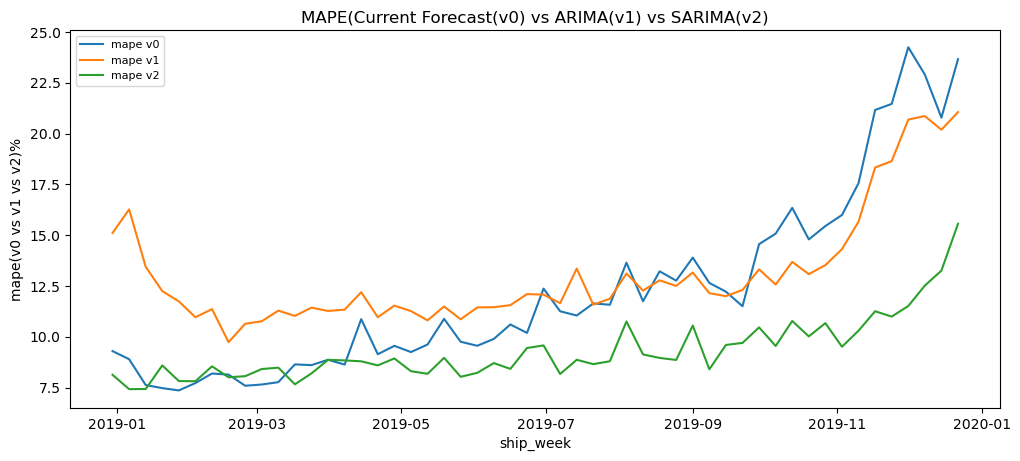

In [170]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mean_result_prop, label='mape v1')
plt.plot(mape_v2, label='mape v2')
plt.title('MAPE(Current Forecast(v0) vs ARIMA(v1) vs SARIMA(v2)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Update wape plot with v0

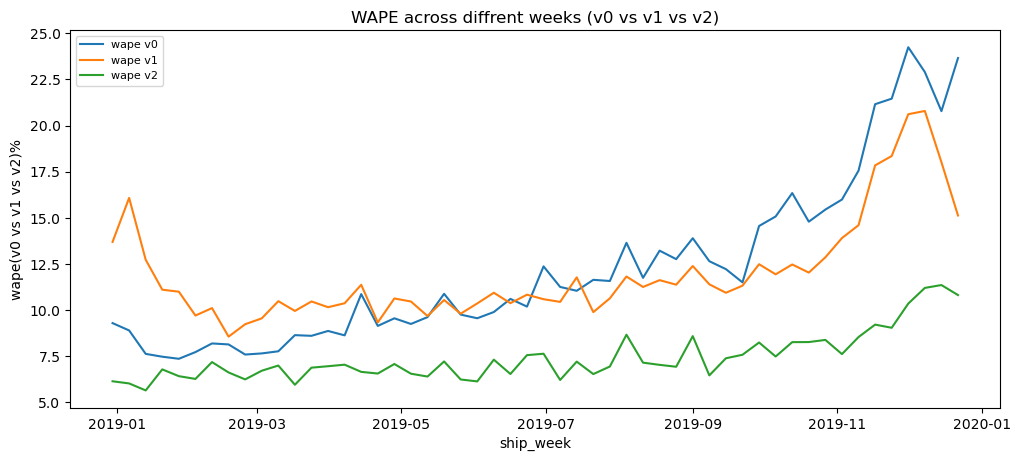

In [171]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_V1, label='wape v1')
plt.plot(wape_v2, label='wape v2')
plt.title('WAPE across diffrent weeks (Current Forecast(v0) vs v1 vs v2)')
plt.xlabel('ship_week')
plt.ylabel ('wape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Average

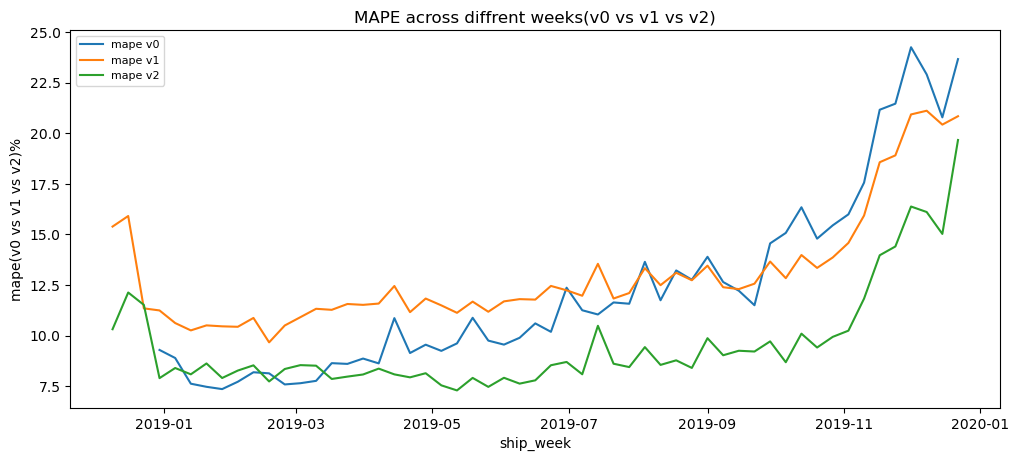

In [172]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mape_v1_upd, label='mape v1')
plt.plot(mape_v2_upd, label='mape v2')
plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

NameError: name 'wape_new_v2' is not defined

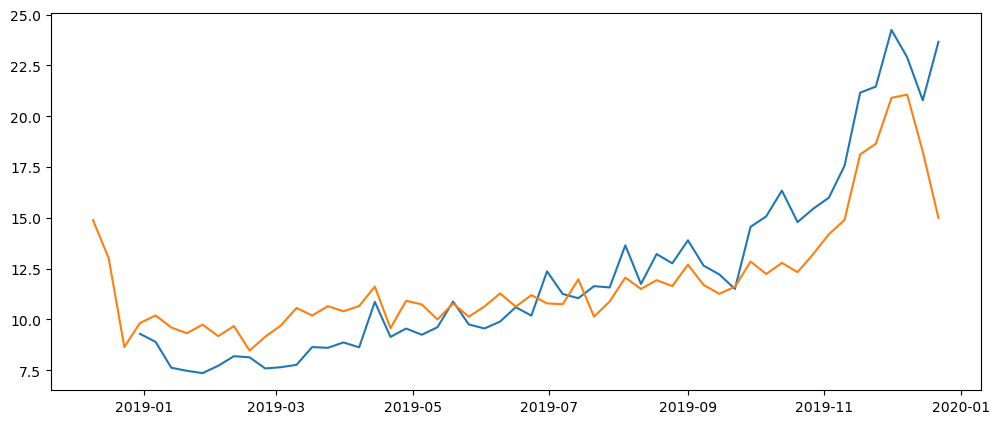

In [173]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_v1_upd, label='wape v1')
plt.plot(wape_new_v2, label='wape v2')
plt.title('WAPE across diffrent weeks (v0 vs v1 vs v2)')
plt.xlabel('ship_week')
plt.ylabel ('wape(v0 vs v1 vs v2)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [22]:
#Percentage short form without 100
FSA = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
FSA

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.000690
           A0B      0.000331
           A0C      0.000205
           A0E      0.000424
           A0G      0.000573
...                      ...
2019-12-22 X0G      0.000001
           X1A      0.000492
           Y0A      0.000004
           Y0B      0.000011
           Y1A      0.000646

[347671 rows x 1 columns]

In [20]:
FSA.loc[pd.to_datetime('2015-12-06')].pkgs.sum()

1.0

In [21]:
FSA.loc[pd.to_datetime('2019-12-22')].pkgs.sum()

0.9999999999999999

In [23]:
#% volume distribution/week/FSA
pct1 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()*100
pct1.head()

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.068974
           A0B      0.033065
           A0C      0.020534
           A0E      0.042438
           A0G      0.057285

In [24]:
pct1.loc[pd.to_datetime('2015-12-06')].pkgs.sum()

100.00000000000009

In [25]:
#% volume distribution/week/FSA
pct2 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()
pct2

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.000690
           A0B      0.000331
           A0C      0.000205
           A0E      0.000424
           A0G      0.000573
...                      ...
2019-12-22 X0G      0.000001
           X1A      0.000492
           Y0A      0.000004
           Y0B      0.000011
           Y1A      0.000646

[347671 rows x 1 columns]

In [26]:
pct2.loc[pd.to_datetime('2015-12-06')].pkgs.sum()

1.0000000000000009

In [27]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

ship_week zipcode      pkgs
0 2015-12-06     A0A  0.000690
1 2015-12-06     A0B  0.000331
2 2015-12-06     A0C  0.000205
3 2015-12-06     A0E  0.000424
4 2015-12-06     A0G  0.000573
5 2015-12-06     A0H  0.000320
6 2015-12-06     A0J  0.000187
7 2015-12-06     A0K  0.000325
8 2015-12-06     A0L  0.000194
9 2015-12-06     A0M  0.000145

## APE and MAPE for V0

In [108]:
pct_data1 = pct1.reset_index() # *100
pct_data1

ship_week zipcode      pkgs
0      2015-12-06     A0A  0.068974
1      2015-12-06     A0B  0.033065
2      2015-12-06     A0C  0.020534
3      2015-12-06     A0E  0.042438
4      2015-12-06     A0G  0.057285
...           ...     ...       ...
347666 2019-12-22     X0G  0.000129
347667 2019-12-22     X1A  0.049162
347668 2019-12-22     Y0A  0.000356
347669 2019-12-22     Y0B  0.001100
347670 2019-12-22     Y1A  0.064633

[347671 rows x 3 columns]

In [41]:
# df = pd.read_excel(r'FSA_Mix/Updated_FSA_Mix.xlsx', engine='openpyxl', sheet_name='FSA Mix %')[['FSA','AMZN Region','City', 'Previous FSA MIX %', 'New FSA MIX %']].dropna()
# print(df)

In [80]:
len(df.FSA.unique())

1661

In [23]:
df1 = df['New FSA MIX %'].sum()
df1

1.0

In [83]:
# df.drop(columns=['City'])
# #df2 = df.rename({'a': 'X', 'b': 'Y'}, axis=1)  # new method

In [42]:
# df2 = df.rename({'FSA': 'zipcode'}, axis=1) 
# df2

In [43]:
# result_metric = pd.merge(pct_data2, df2, on=["zipcode"])
# result_metric

In [44]:
#take the difference
# result_metric['APE_V0'] = result_metric['pkgs'] - result_metric['New FSA MIX %']

# result_metric['APE_V0']= result_metric['APE_V0'].abs()

# result_metric.head()

In [45]:
# result_metric['APE'] = result_metric['APE_V0'] / result_metric['pkgs']*100
# result_metric

## V0 MAPE

In [48]:
#MAPE
# mean_result_V0=result_metric.groupby(['ship_week'])[['APE']].mean()
# mean_result_V0

In [49]:
# mape_v0 = mean_result_V0[mean_result_V0.index >'2020-07-04']
# mape_v0.head()

In [307]:
mape_pp_v0 = mape_v0.reset_index()

In [50]:
# pp_v0 = mape_pp_v0[(mape_pp_v0['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# pp_v0

In [309]:
m_pp_st = pp_v0.set_index('ship_week')

In [51]:
# mean_result_V0[mean_result_V0['APE'] < 10].head()

In [52]:
# mean_result_V0[mean_result_V0['APE'] > 10]

## WAPE V0

In [53]:
# result_metric_new = pd.merge(pct_data2, df2, on=["zipcode"])
# result_metric_new

In [54]:
#take the difference
# result_metric_new['APE_V0'] = result_metric_new['pkgs'] - result_metric_new['New FSA MIX %']

# result_metric_new['APE_V0']= result_metric_new['APE_V0'].abs()

# result_metric_new.head()

In [55]:
# result_metric_new['APE'] = result_metric_new['APE_V0'] / result_metric_new['pkgs']
# result_metric_new

In [56]:
# def my_agg(y):
#     names = {'weighted_avg_V0': (y['pkgs'] * y['APE']).sum()/y['pkgs'].sum()}
#     return pd.Series(names, index=['weighted_avg_V0'])

In [57]:
# wape_V0 = result_metric_new.groupby(["ship_week"]).apply(my_agg)*100
# wape_V0

In [28]:
import datetime

In [58]:
# wape_V0[wape_V0.index >'2020-07-04'].head()

In [60]:
# v0 = wape_V0[wape_V0.index >'2020-07-04']
# v0.head()

In [159]:
v0_reset = v0.reset_index()

In [61]:
# wape_pp_v0 = v0_reset[(v0_reset['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# wape_pp_v0

In [161]:
wape_st_v0 = wape_pp_v0.set_index('ship_week')

In [30]:
v0_reset = v0.reset_index()
v0_reset.head()

ship_week  weighted_avg_V0
0 2020-07-05         6.989394
1 2020-07-12         6.649872
2 2020-07-19         6.439387
3 2020-07-26         6.783429
4 2020-08-02         5.760443

## V1

In [163]:
#mape
mean_result_prop.head()

APE
ship_week           
2020-07-12  5.396214
2020-07-19  5.174848
2020-07-26  5.961998
2020-08-02  6.654951
2020-08-09  6.912959

In [164]:
wape_V1.head()

weighted_avg_mix
ship_week                   
2020-07-12          3.802993
2020-07-19          3.868363
2020-07-26          4.544094
2020-08-02          4.988723
2020-08-09          5.771849

## V2

In [165]:
#wape
wape_v2.head()

weighted_v2_mix
ship_week                  
2020-07-12         6.253401
2020-07-19         4.647838
2020-07-26         4.837313
2020-08-02         4.762592
2020-08-09         5.221463

In [166]:
#mape
mape_v2.head()

APE
ship_week           
2020-07-12  9.572900
2020-07-19  6.184115
2020-07-26  6.943999
2020-08-02  6.968033
2020-08-09  7.132856

## WAPE PLOTS

In [46]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(v0, label='wape v0')
# plt.plot(wape_V1, label='wape v1')
# plt.plot(wape_v2, label='wape v2')
# plt.title('WAPE across diffrent weeks (v0 vs v1 vs v2)')
# plt.xlabel('ship_week')
# plt.ylabel ('wape(v0 vs v1 vs v2)%')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

## MAPE PLOTS

In [47]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(mape_v0, label='mape v0')
# plt.plot(mean_result_prop, label='mape v1')
# plt.plot(mape_v2, label='mape v2')
# plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
# plt.xlabel ('ship_week')
# plt.ylabel ('mape(v0 vs v1 vs v2)%')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

## Prime and peak mnth

In [265]:
pp_v1_m = mape_pp_v1.set_index('ship_week')
pp_v1_m

APE
ship_week            
2020-07-12   5.396210
2020-07-19   5.174839
2020-07-26   5.961997
2020-11-01  11.842142
2020-11-08  13.283745
2020-11-15  13.863051
2020-11-22  14.838659
2020-11-29  15.991570
2020-12-06  14.401518
2020-12-13  17.419339
2020-12-20  25.042548
2020-12-27  15.480066

In [268]:
pp_v2_m = mape_pp_v2.set_index('ship_week')
pp_v2_m

APE
ship_week            
2020-07-12   9.572903
2020-07-19   6.184121
2020-07-26   6.944000
2020-11-01  12.496057
2020-11-08  12.736556
2020-11-15  11.723489
2020-11-22  12.896036
2020-11-29  13.612861
2020-12-06  13.628414
2020-12-13  16.821853
2020-12-20  20.623425
2020-12-27  13.739381

In [112]:
# Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(m_pp_st, label='mape v0')
# plt.plot(pp_v1_m, label='mape v1')
# plt.plot(pp_v2_m, label='mape v2')
# plt.title('v0 vs v1 vs v2')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [279]:
pp_st_v2 = wape_pp_v2.set_index('ship_week')

In [280]:
pp_st_v1 = wape_pp_v1.set_index('ship_week')

In [113]:
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(wape_st_v0, label='wape v0')
# plt.plot(pp_st_v1, label='wape v1')
# plt.plot(pp_st_v2, label='wape v2')
# plt.title('v0 vs v1 vs v2')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

In [128]:
result_metric_new.index.dtype

dtype('int64')

In [148]:
# result_metric_new

In [ ]:
# pct2 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()
# pct2

In [102]:
# result_metric1 = result_metric.groupby(['ship_week'])[['pkgs']].sum()
# result_metric1

In [97]:
# result = pd.merge(pct_data2, df2, left_index=True, right_index=True, how="inner")
# result

In [98]:
# result = pd.merge(pct_data2, df2, left_index=True, right_index=True, how="right")
# result

In [99]:
# #take the difference
# result['APE_diff'] = result['New FSA MIX %'] - result['pkgs']

# result['APE_abs']= result['APE_diff'].abs()

# result.head()

In [100]:
# result['APE'] = result['APE_abs'] / result['pkgs']
# result

In [ ]:
# result_metric = pd.merge(df_fct, mod_reset, on=["zipcode", "ship_week"])
# result_metric

In [101]:
# #MAPE
# mean_result= result.groupby(['ship_week'])[['APE']].mean()
# mean_result

In [101]:
# plt.hist(result['APE'],bins=100)

In [39]:
#merge the old and new dataframes; m and mod_df

# merge_inner = mod_df.merge (df, left_on=['New FSA MIX %', 'AMZN Region'], right_on =['ship_week'])
                       
# merge_inner.head(5)



## Visualize porportions 

In [26]:
#pct_data1[pct_data1['ship_week']=='2017-05-28', '2018-05-28' ].head(8)

## V2 Model for FSA errors

In [94]:
mod_20 = mod_df[(mod_df['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
mod_20

zipcode  pkgs
ship_week               
2015-12-06     B1M    37
2015-12-06     B1W    25
2015-12-06     H3A  1061
2015-12-06     H3B   812
2015-12-06     H4T   338
...            ...   ...
2019-12-22     V6C  1135
2019-12-22     V7X   181
2019-12-22     V7Y   106
2019-12-22     X0C    67
2019-12-22     Y0A    11

[4237 rows x 2 columns]

In [95]:
mean_20= mod_20.groupby(['zipcode'], sort=False).mean()
mean_20

pkgs
zipcode             
B1M        56.863208
B1W        44.764151
H3A      1457.330189
H3B      1018.452830
H4T       342.801887
H4Y        16.424528
H4Z        38.778302
H5B        41.198113
K1A       204.721698
K1P       398.825472
L5P         8.331754
M5K       135.801887
M5L        58.457547
M5X       139.551887
T0P         7.395238
V6C      1243.283019
V7X       224.099057
V7Y       168.943396
X0C        46.867925
Y0A         7.556604

In [96]:
mod_20_sum= mod_20.groupby(['zipcode'], sort=False).sum()
mod_20_sum

pkgs
zipcode        
B1M       12055
B1W        9490
H3A      308954
H3B      215912
H4T       72674
H4Y        3482
H4Z        8221
H5B        8734
K1A       43401
K1P       84551
L5P        1758
M5K       28790
M5L       12393
M5X       29585
T0P        1553
V6C      263576
V7X       47509
V7Y       35816
X0C        9936
Y0A        1602

In [97]:
sum_20_sort = mod_20_sum.sort_values('pkgs', ascending=False)
sum_20_sort

pkgs
zipcode        
H3A      308954
V6C      263576
H3B      215912
K1P       84551
H4T       72674
V7X       47509
K1A       43401
V7Y       35816
M5X       29585
M5K       28790
M5L       12393
B1M       12055
X0C        9936
B1W        9490
H5B        8734
H4Z        8221
H4Y        3482
L5P        1758
Y0A        1602
T0P        1553

In [98]:
mod_20_rst = mod_20.reset_index()

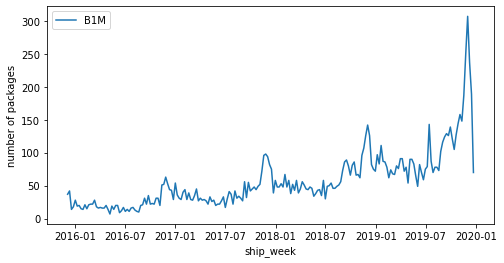

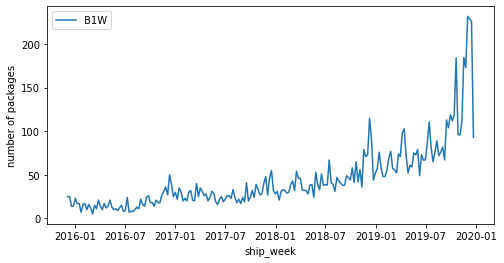

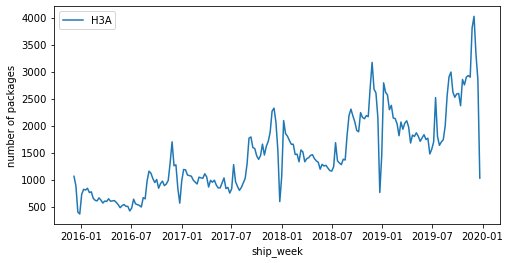

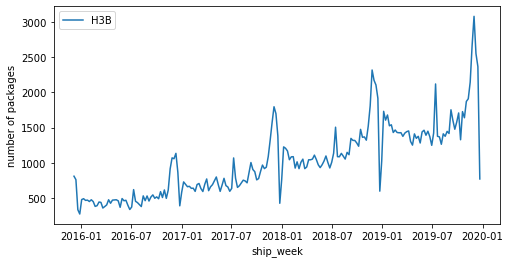

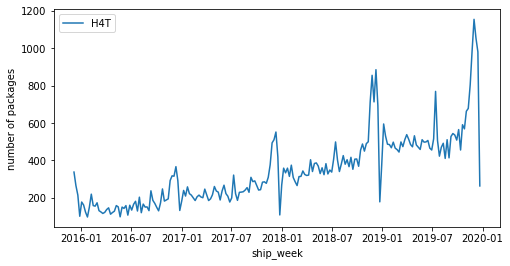

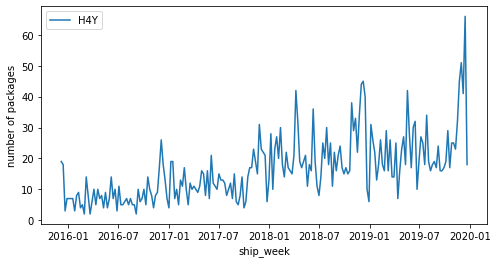

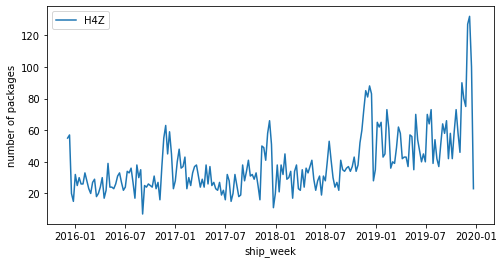

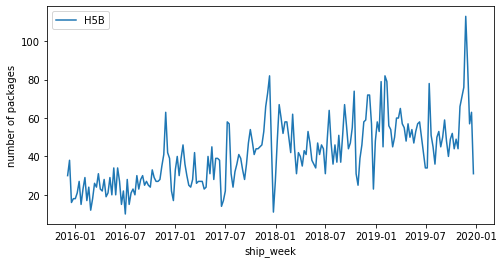

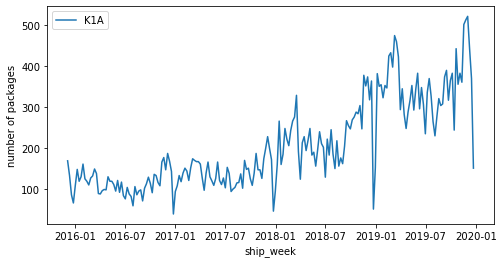

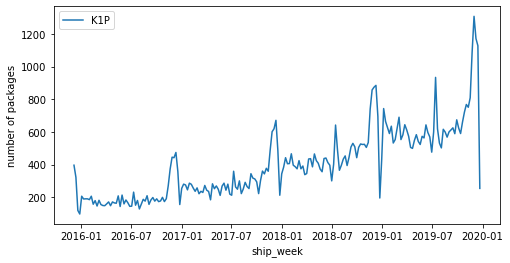

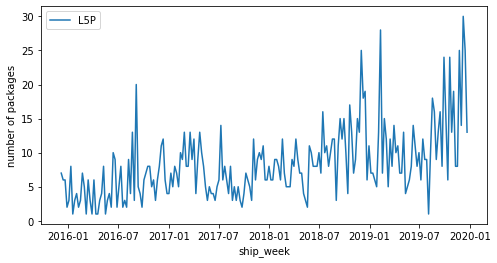

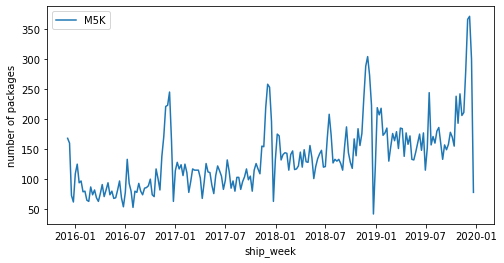

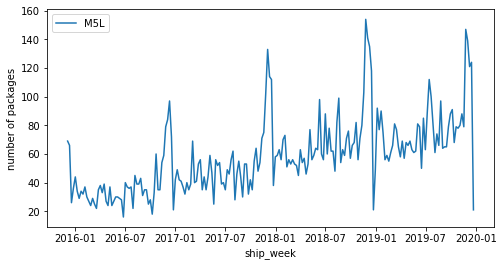

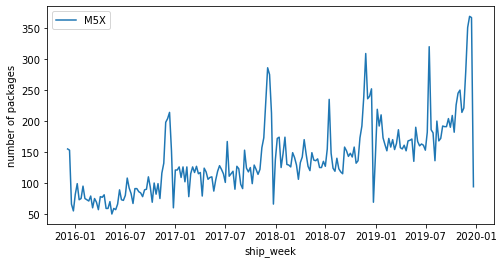

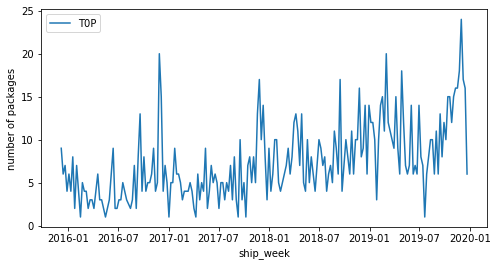

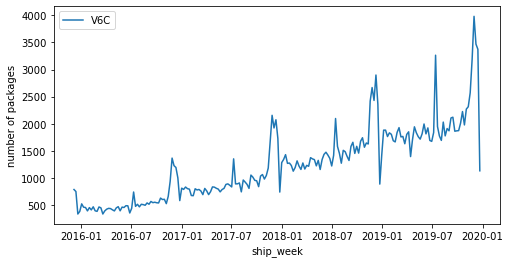

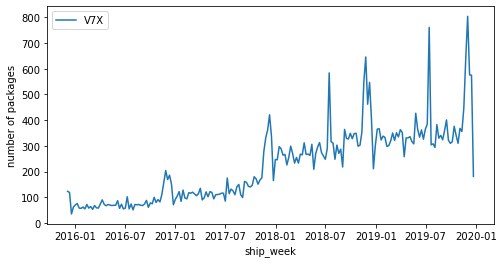

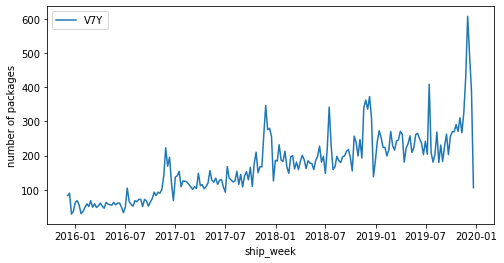

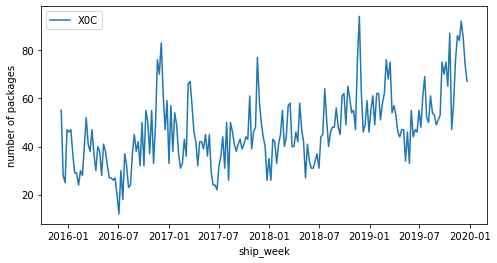

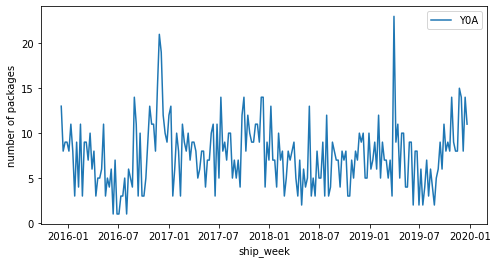

In [99]:
for key, grp in mod_20_rst.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('number of packages')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()

In [100]:
viz_pct_20 = pct_data1[(pct_data1['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
viz_pct_20

ship_week zipcode      pkgs
58     2015-12-06     B1M  0.003896
65     2015-12-06     B1W  0.002633
407    2015-12-06     H3A  0.111728
408    2015-12-06     H3B  0.085507
441    2015-12-06     H4T  0.035593
...           ...     ...       ...
347586 2019-12-22     V6C  0.036734
347621 2019-12-22     V7X  0.005858
347622 2019-12-22     V7Y  0.003431
347664 2019-12-22     X0C  0.002168
347668 2019-12-22     Y0A  0.000356

[4237 rows x 3 columns]

In [101]:
pct_data1

ship_week zipcode      pkgs
0      2015-12-06     A0A  0.068974
1      2015-12-06     A0B  0.033065
2      2015-12-06     A0C  0.020534
3      2015-12-06     A0E  0.042438
4      2015-12-06     A0G  0.057285
...           ...     ...       ...
347666 2019-12-22     X0G  0.000129
347667 2019-12-22     X1A  0.049162
347668 2019-12-22     Y0A  0.000356
347669 2019-12-22     Y0B  0.001100
347670 2019-12-22     Y1A  0.064633

[347671 rows x 3 columns]

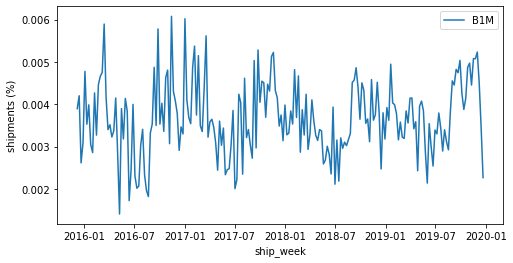

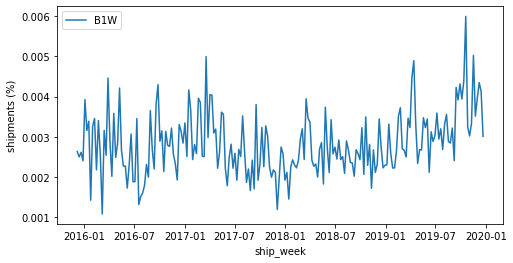

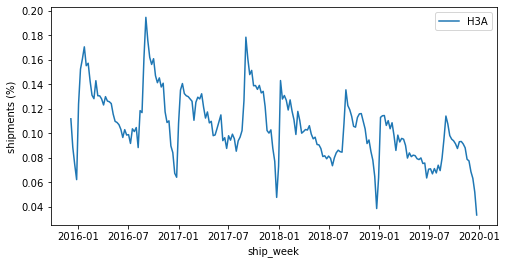

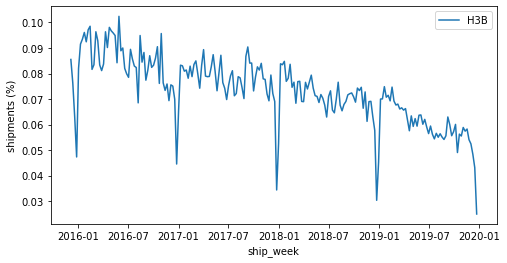

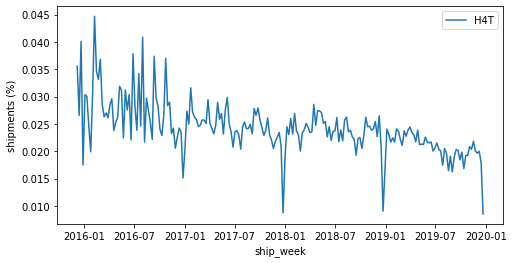

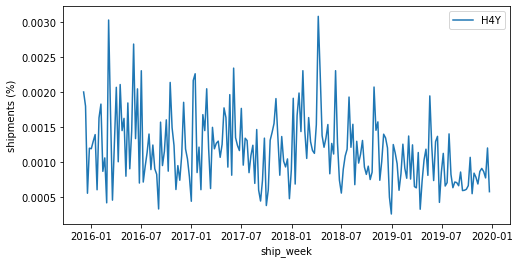

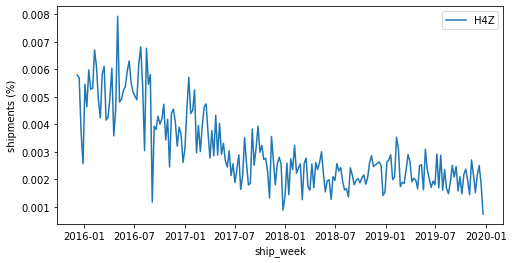

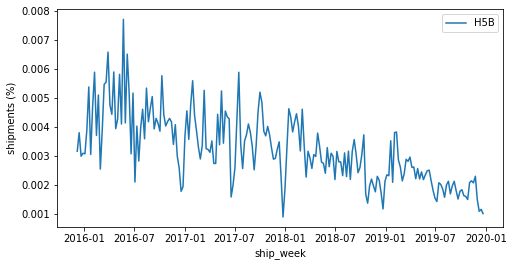

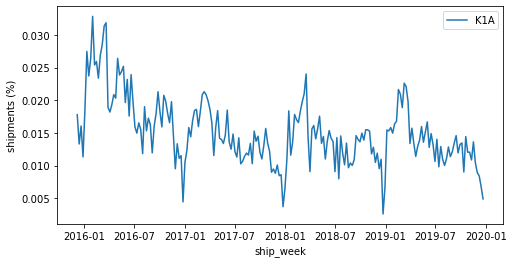

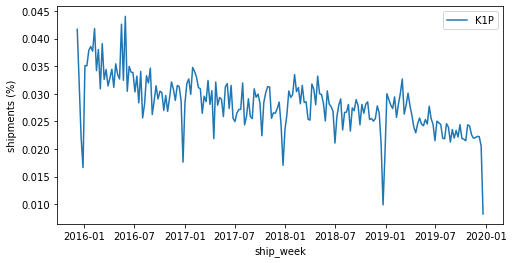

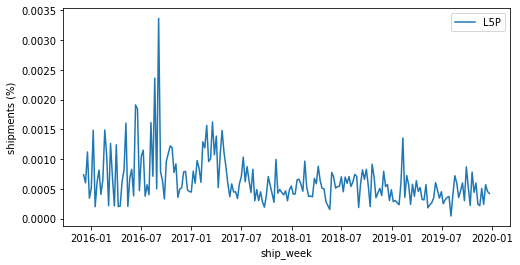

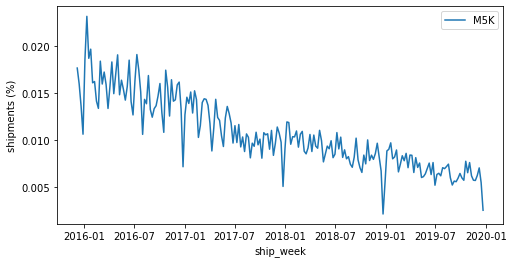

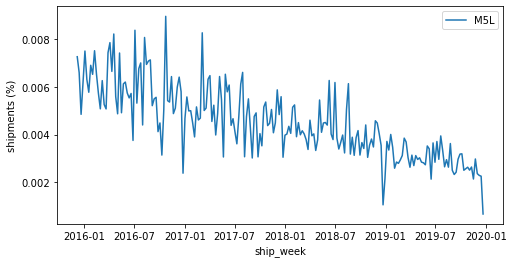

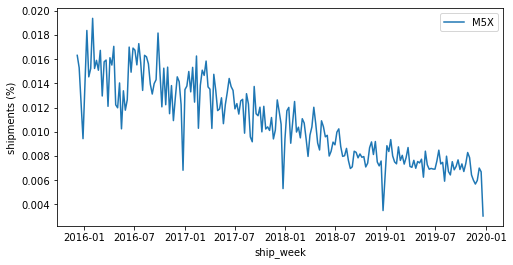

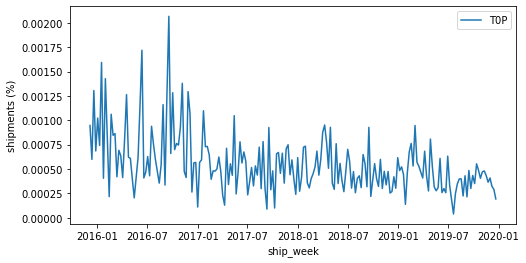

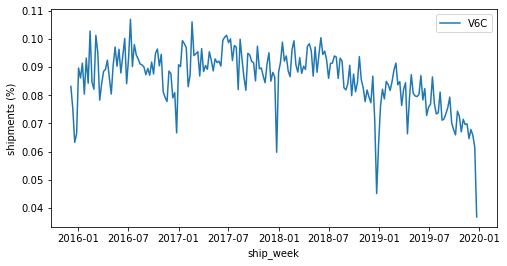

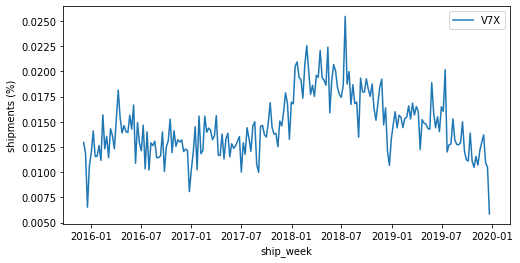

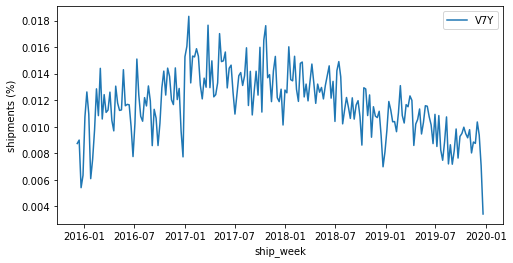

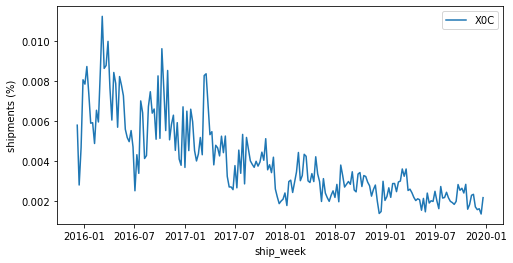

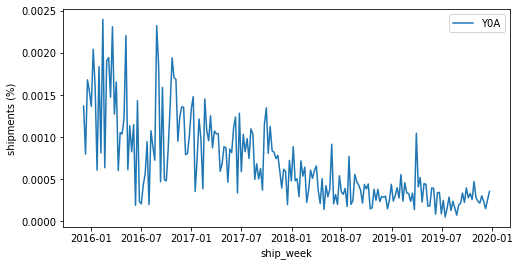

In [102]:
# multiplied by 100

for key, grp in viz_pct_20.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('shipments (%)')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()

## Proportion Visuals for all the eight FSA

In [103]:
#pct_data1[pct_data1['ship_week']=='2017-05-28']
#viz_pct = pct_data1[(pct_data1['ship_week']=='2017-05-28','2018-05-28') & 
                    #(pct_data1['zipcode'].isin(['A0A', 'A0B', 'A0C', 'A0E']))]
    
    
viz_pct = pct_data1[(pct_data1['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
viz_pct

ship_week zipcode      pkgs
339    2015-12-06     G7Z  0.002527
346    2015-12-06     G8J  0.002843
366    2015-12-06     H0M  0.000105
409    2015-12-06     H3C  0.074661
653    2015-12-06     K0K  0.324968
...           ...     ...       ...
346426 2019-12-22     H3C  0.073468
346670 2019-12-22     K0K  0.298243
347013 2019-12-22     N0B  0.229306
347195 2019-12-22     R0K  0.036184
347548 2019-12-22     V4B  0.052852

[1666 rows x 3 columns]

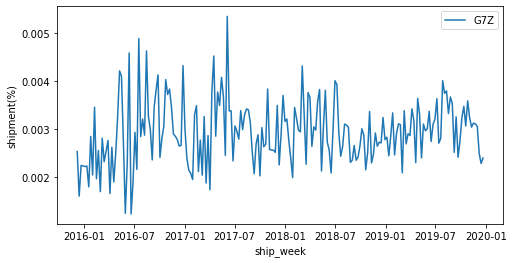

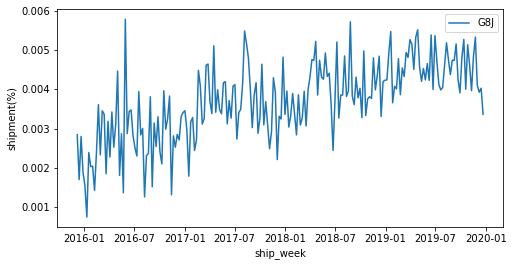

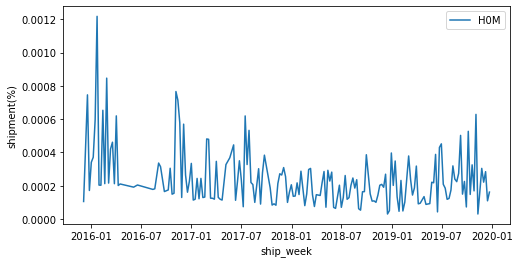

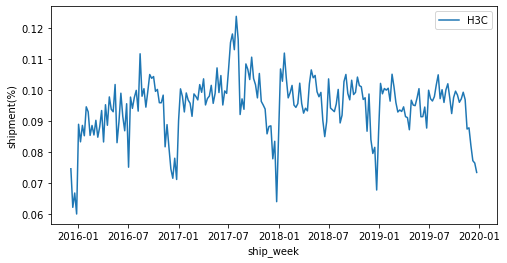

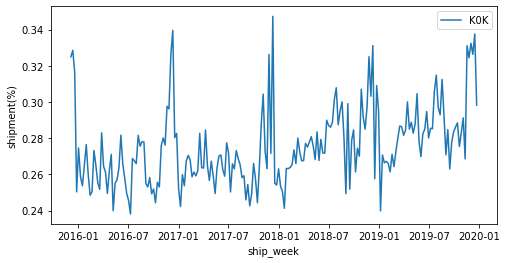

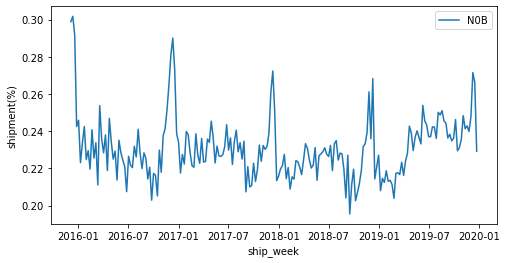

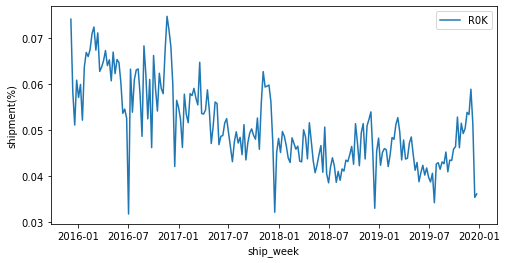

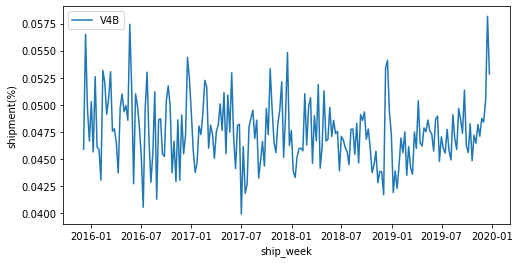

In [104]:
#multiplied by 100
#fig, ax = plt.subplots(figsize=(10,4))
for key, grp in viz_pct.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('shipment(%)')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()
    #plt.close()

## Package distribution 

In [105]:
pkg_num = mod_df[(mod_df['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pkg_num

zipcode  pkgs
ship_week               
2015-12-06     G7Z    24
2015-12-06     G8J    27
2015-12-06     H0M     1
2015-12-06     H3C   709
2015-12-06     K0K  3086
...            ...   ...
2019-12-22     H3C  2270
2019-12-22     K0K  9215
2019-12-22     N0B  7085
2019-12-22     R0K  1118
2019-12-22     V4B  1633

[1666 rows x 2 columns]

In [106]:
pkg_num_rst = pkg_num.reset_index()

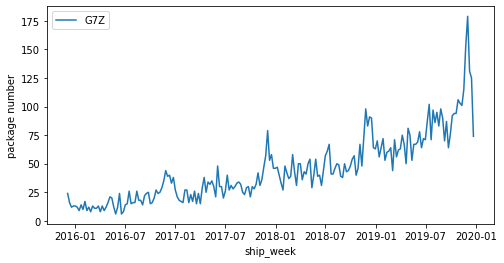

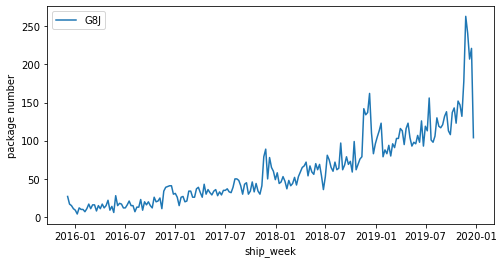

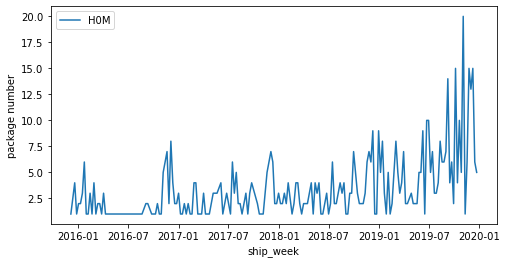

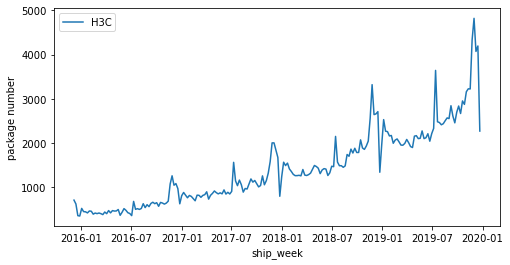

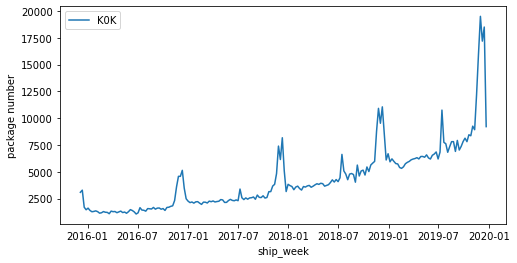

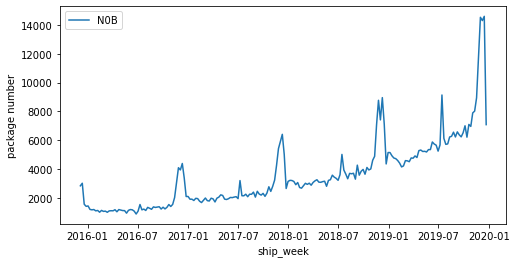

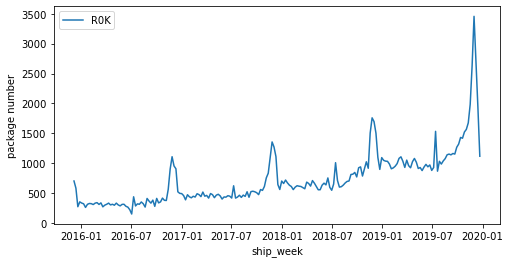

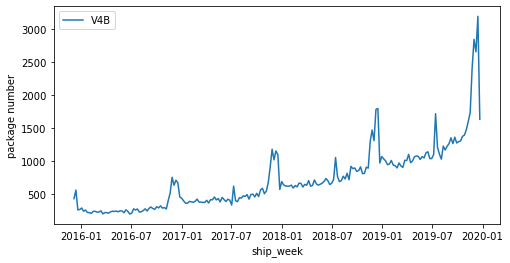

In [107]:
for key, grp in pkg_num_rst.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pkgs'], label=key)
    plt.ylabel('package number')
    plt.xlabel('ship_week')
    plt.legend()
    plt.show()

In [108]:
df= mod_df.groupby(['zipcode'], sort=False)
df.head()

zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-09-08     R5P    21
2019-09-08     R5R    33
2019-09-15     S7A     1
2019-09-22     S7A     1
2019-10-20     V7Z     1

[8293 rows x 2 columns]

In [109]:
#avg of number of packages/postal codes 
FSA_df= mod_df.groupby(['zipcode'], sort=False).mean()
FSA_df.head()

pkgs
zipcode            
A0A      615.150943
A0B      315.292453
A0C      163.797170
A0E      347.952830
A0G      577.707547

In [110]:
#postalcodes that have < 7 shippment/week on the average
FSA_df[FSA_df['pkgs'] < 7]

pkgs
zipcode          
E2R      4.394286
H0M      3.571429
R1B      4.800995
S0P      5.719048
T0V      2.453947
X0G      2.973545
N8V      2.393258
S4M      4.601852
V0W      2.173913
S4K      6.600000
T6Y      3.900000
T3T      4.814815
J5N      1.076923
V7Z      1.625000
V0Y      1.666667
T0W      1.333333
S7A      6.333333

In [111]:
#zipcodes placed in percentiles 
df_pct = pd.cut(FSA_df.pkgs, np.percentile(FSA_df.pkgs, [0, 1, 5, 25, 50, 75, 95, 99, 100]),
                  include_lowest=True)
df_pct

zipcode
A0A    (295.861, 682.41]
A0B    (295.861, 682.41]
A0C    (48.328, 295.861]
A0E    (295.861, 682.41]
A0G    (295.861, 682.41]
             ...        
R5L    (48.328, 295.861]
R5N    (48.328, 295.861]
R5T      (7.061, 48.328]
R5P      (7.061, 48.328]
R5R    (48.328, 295.861]
Name: pkgs, Length: 1659, dtype: category
Categories (8, interval[float64]): [(1.076, 7.061] < (7.061, 48.328] < (48.328, 295.861] < (295.861, 682.41] < (682.41, 1278.542] < (1278.542, 2517.085] < (2517.085, 4191.936] < (4191.936, 9035.146]]

In [112]:
df_pct1 = df_pct.cat.rename_categories([1, 5, 25, 50, 75, 95, 99, 100])
df_pct1

zipcode
A0A    50
A0B    50
A0C    25
A0E    50
A0G    50
       ..
R5L    25
R5N    25
R5T     5
R5P     5
R5R    25
Name: pkgs, Length: 1659, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [113]:
df_pct2 = df_pct1.groupby('zipcode').nunique()  #find out what to do here 

In [114]:
df_pct3 = df_pct1.groupby(df_pct1).sample(n=1, random_state=1)
df_pct3

zipcode
S0P      1
G7Z      5
K1X     25
J7Z     50
K1E     75
V5N     95
T3E     99
L5M    100
Name: pkgs, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [115]:
df_pct3 = df_pct1.groupby(df_pct1).sample(n=1)
df_pct3

zipcode
S0P      1
B0L      5
J7H     25
B3N     50
T5R     75
V6Z     95
M4C     99
L5M    100
Name: pkgs, dtype: category
Categories (8, int64): [1 < 5 < 25 < 50 < 75 < 95 < 99 < 100]

In [62]:
sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2019-12-29'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, '2019-12-29' )))))
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in ('H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K')
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [63]:
eigt_FSA =pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
eigt_FSA

zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-12-22     X0G     4
2019-12-22     X1A  1519
2019-12-22     Y0A    11
2019-12-22     Y0B    34
2019-12-22     Y1A  1997

[347671 rows x 2 columns]

In [64]:
mod_8 = mod_df[(mod_df['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
mod_8

zipcode  pkgs
ship_week               
2015-12-06     G7Z    24
2015-12-06     G8J    27
2015-12-06     H0M     1
2015-12-06     H3C   709
2015-12-06     K0K  3086
...            ...   ...
2019-12-22     H3C  2270
2019-12-22     K0K  9215
2019-12-22     N0B  7085
2019-12-22     R0K  1118
2019-12-22     V4B  1633

[1666 rows x 2 columns]

In [65]:
#% volume distribution/week/FSA..for all FSAs
pct = eigt_FSA.groupby(['ship_week','zipcode']).sum()/eigt_FSA.groupby(['ship_week']).sum()*100
pct.head()

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.068974
           A0B      0.033065
           A0C      0.020534
           A0E      0.042438
           A0G      0.057285

In [15]:
#% volume distribution/week/FSA
#pct1 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()*100
#pct1.head()

In [18]:
#pct_data1 = pct1.reset_index()
#pct_data1.head()

In [19]:
#for key, grp in pct_data.groupby(['zipcode']):
    #fig, ax = plt.subplots(figsize=(10,4))
    #plt.plot( grp['pkgs'], label=key)
    #plt.legend()
    #plt.show()
    #plt.close()

In [32]:
pct.loc[pd.to_datetime('2015-12-06')].pkgs.sum()

100.0

In [ ]:
#data_pred = pred.to_frame()
#data_pred1 = data_pred.reset_index()
#data_pred1.columns =['ship_week', 'pkgs_num']
#data_pred1.head(10)

In [66]:
pct_data = pct.reset_index()
pct_data.head()

ship_week zipcode      pkgs
0 2015-12-06     A0A  0.068974
1 2015-12-06     A0B  0.033065
2 2015-12-06     A0C  0.020534
3 2015-12-06     A0E  0.042438
4 2015-12-06     A0G  0.057285

In [97]:
#fig, ax = plt.subplots(figsize=(10,4))
#for key, grp in pct_data.groupby(['zipcode']):
    #fig, ax = plt.subplots(figsize=(10,4))
    #plt.plot(grp[''] grp['pkgs'], label=key)
    #plt.legend()
    #plt.show()
    #plt.close()

In [57]:
#import multiprocessing
#multiprocessing.cpu_count().....8

In [12]:
#avg of number of packages/postal codes 
new_FSA= eigt_FSA.groupby(['zipcode'], sort=False).mean()
new_FSA

pkgs
zipcode             
G7Z        44.457547
G8J        60.825472
H0M         3.571429
H3C      1423.943396
K0K      4286.103774
N0B      3530.570755
R0K       730.141509
V4B       718.466981

array([[<AxesSubplot:title={'center':'pkgs'}>]], dtype=object)

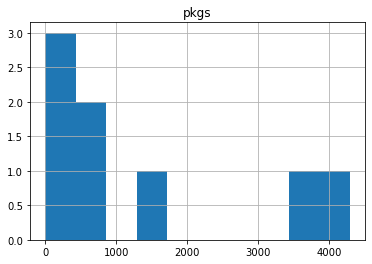

In [35]:
#avg of number of packages/postal codes 
new_FSA= eigt_FSA.groupby(['zipcode'], sort=False).mean()
new_FSA.head(10).hist()

In [36]:
FSA_sum= eigt_FSA.groupby(['zipcode'], sort=False).sum()
FSA_sum

pkgs
zipcode        
G7Z        9425
G8J       12895
H0M         650
H3C      301876
K0K      908654
N0B      748481
R0K      154790
V4B      152315

## Absolute Visuals

In [28]:
# sea_grp = eigt_FSA.groupby('zipcode')
# for key in sea_grp.groups.keys():
#     sea_grp.get_group(key).plot(title=key)

## R0K Postalcode for analysis

In [67]:
#extract R0K data for analysis
post_code = eigt_FSA[eigt_FSA.zipcode == 'R0K']
post_code

zipcode  pkgs
ship_week               
2015-12-06     R0K   704
2015-12-13     R0K   584
2015-12-20     R0K   274
2015-12-27     R0K   355
2016-01-03     R0K   335
...            ...   ...
2019-11-24     R0K  2632
2019-12-01     R0K  3457
2019-12-08     R0K  2710
2019-12-15     R0K  1942
2019-12-22     R0K  1118

[212 rows x 2 columns]

In [68]:
m_code = post_code.reset_index()
m_code

ship_week zipcode  pkgs
0   2015-12-06     R0K   704
1   2015-12-13     R0K   584
2   2015-12-20     R0K   274
3   2015-12-27     R0K   355
4   2016-01-03     R0K   335
..         ...     ...   ...
207 2019-11-24     R0K  2632
208 2019-12-01     R0K  3457
209 2019-12-08     R0K  2710
210 2019-12-15     R0K  1942
211 2019-12-22     R0K  1118

[212 rows x 3 columns]

In [69]:
m_code[m_code['ship_week']=='2019-12-22']

ship_week zipcode  pkgs
211 2019-12-22     R0K  1118

In [40]:
post_code.reset_index().ship_week.min()

Timestamp('2015-12-06 00:00:00')

In [41]:
post_code.reset_index().ship_week.max()

Timestamp('2019-12-22 00:00:00')

In [42]:
len(post_code.reset_index().ship_week.unique())

212

## Split data

In [70]:
#split data: Train (3 years; 160weeks), Test (1 year; 52weeks),and Forecast (3 years; 325weeks)

train_data = post_code[-4*212:160]
test_data = post_code[-52:]
fcst_data = post_code[-3*52:]

In [71]:
post_code

zipcode  pkgs
ship_week               
2015-12-06     R0K   704
2015-12-13     R0K   584
2015-12-20     R0K   274
2015-12-27     R0K   355
2016-01-03     R0K   335
...            ...   ...
2019-11-24     R0K  2632
2019-12-01     R0K  3457
2019-12-08     R0K  2710
2019-12-15     R0K  1942
2019-12-22     R0K  1118

[212 rows x 2 columns]

In [72]:
fcst_data = post_code[-3*52:]
fcst_data

zipcode  pkgs
ship_week               
2017-01-01     R0K   493
2017-01-08     R0K   460
2017-01-15     R0K   389
2017-01-22     R0K   474
2017-01-29     R0K   440
...            ...   ...
2019-11-24     R0K  2632
2019-12-01     R0K  3457
2019-12-08     R0K  2710
2019-12-15     R0K  1942
2019-12-22     R0K  1118

[156 rows x 2 columns]

In [73]:
train_data = post_code[-4*212:160]
train_data

zipcode  pkgs
ship_week               
2015-12-06     R0K   704
2015-12-13     R0K   584
2015-12-20     R0K   274
2015-12-27     R0K   355
2016-01-03     R0K   335
...            ...   ...
2018-11-25     R0K  1760
2018-12-02     R0K  1697
2018-12-09     R0K  1504
2018-12-16     R0K  1098
2018-12-23     R0K   898

[160 rows x 2 columns]

In [58]:
train_data.shape

(160, 2)

In [17]:
type(train_data)

pandas.core.frame.DataFrame

In [47]:
test_data = post_code[-52:]
#test_data

In [128]:
type(test_data)

pandas.core.frame.DataFrame

## Dipslay the MIN and MAX of the divided datasets 

In [48]:
m = train_data.reset_index()
m.ship_week.min()

Timestamp('2015-12-06 00:00:00')

In [49]:
m.ship_week.max()

Timestamp('2018-12-23 00:00:00')

In [224]:
m[m['ship_week']=='2020-06-21']

Empty DataFrame
Columns: [ship_week, zipcode, pkgs]
Index: []

In [50]:
m1 = test_data.reset_index()
m1.ship_week.min()

Timestamp('2018-12-30 00:00:00')

In [51]:
m1.ship_week.max()

Timestamp('2019-12-22 00:00:00')

In [52]:
m2 = fcst_data.reset_index()
m2.ship_week.min()

Timestamp('2017-01-01 00:00:00')

In [53]:
m2.ship_week.max()

Timestamp('2019-12-22 00:00:00')

## Visualize training and testing 

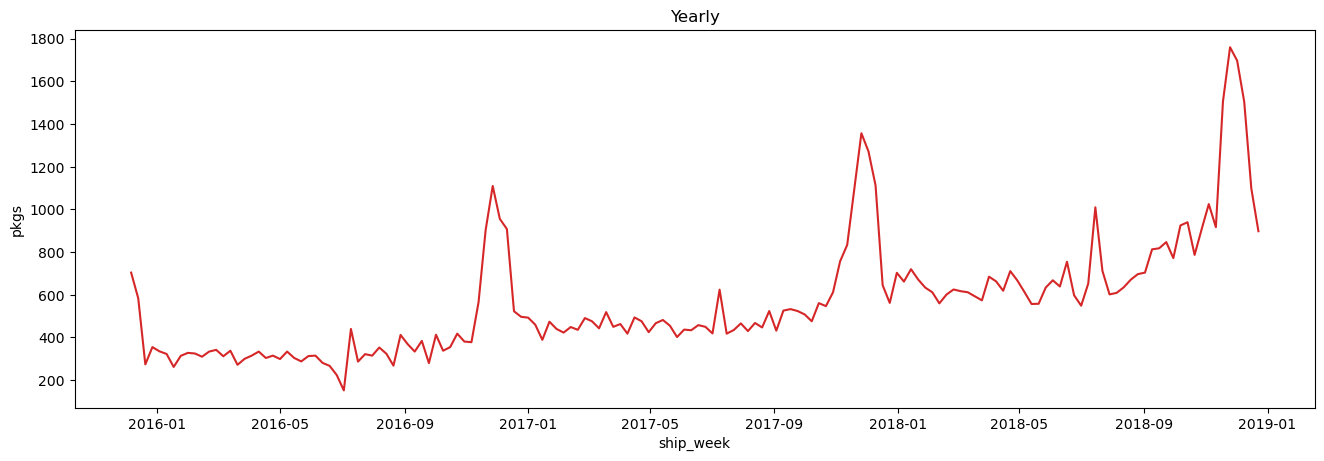

In [54]:
#train data visuals

def plot_train_data(train_data, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    #q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_train_data(train_data, x=train_data.index, y=train_data.pkgs, title='Yearly')    


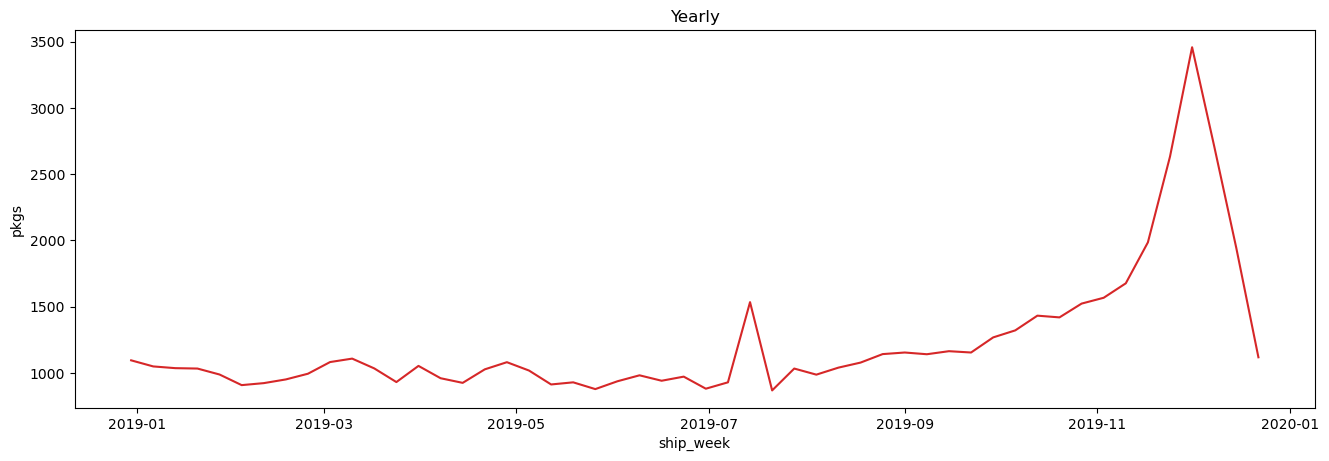

In [55]:
#visualize test data to check the similarity

def plot_test_data(test_data, x, y, title="", xlabel='ship_week', ylabel='pkgs', dpi=100):
    #q.groupby('zipcode')['pkgs'].plot(legend=True)
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_test_data(test_data, x=test_data.index, y=test_data.pkgs, title='Yearly')

## Fitting Model 

## Moving Average

In [74]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA 


In [75]:
#train
train_data = post_code[-4*212:160]

#test
test_data = post_code[-52:]

#forecast
fcst_data = post_code[-3*52:]

In [76]:
#train
train_data = post_code[-4*212:160]

In [77]:
train_data1 = train_data.iloc[:,1]
train_data1

ship_week
2015-12-06     704
2015-12-13     584
2015-12-20     274
2015-12-27     355
2016-01-03     335
              ... 
2018-11-25    1760
2018-12-02    1697
2018-12-09    1504
2018-12-16    1098
2018-12-23     898
Name: pkgs, Length: 160, dtype: int64

In [61]:
test_data = post_code[-52:]
test_data1 = test_data.iloc[:,1]
#test_data1

## Transformed data modelling 

In [15]:
#train_data_diff = train_data1.diff()
# train_data_diff = train_data1.diff().fillna(train_data1)
# pyplot.plot(train_data_diff)
# plt.show()

In [62]:
# train_data_diff

In [16]:
# train_data_diff2 = train_data_diff.diff().fillna(train_data_diff)
# pyplot.plot(train_data_diff2)
# plt.show()

In [63]:
# train_data_diff2

In [17]:
# train_data_diff3 = train_data_diff2.diff().fillna(train_data_diff2)
# pyplot.plot(train_data_diff3)
# plt.show()

In [64]:
# train_data_diff3

In [18]:
# plot_acf(train_data_diff2, lags=20)

In [19]:
# plot_pacf(train_data_diff2, lags=20)

## Fit the MA model 

In [21]:
#AR(0) & MA(1).
model = ARIMA(train_data1, order=(1,1,3))
model_fit = model.fit()
model_fit.summary()

/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  160
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -983.618
Date:                Fri, 30 Jul 2021   AIC                           1977.236
Time:                        16:03:57   BIC                           1992.581
Sample:                    12-06-2015   HQIC                          1983.467
                         - 12-23-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6913      0.227      3.045      0.002       0.246       1.136
ma.L1         -0.6647      0.226     -2.938      0.003      -1.108      -0.221
ma.L2         -0.1175      0.107     -1.101      0.271      -0.327       0.092
ma.L3         -0.1334      0.124     -1.074      0.283      -0.377       0.110
sigma2      1.378e+04    899.173     15.325      0.000     1.2e+04    1.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               260.46
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             1.08
Prob(H) (two-sided):                  0.03   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
#prediction on the test data
#test_data1 = test_data.iloc[:,1]
pred_model = model_fit.predict(start=160, end=160+52-1)
pred_model

2018-12-30    852.442312
2019-01-06    865.161821
2019-01-13    885.886231
2019-01-20    900.212830
2019-01-27    910.116681
2019-02-03    916.963124
2019-02-10    921.696009
2019-02-17    924.967811
2019-02-24    927.229578
2019-03-03    928.793117
2019-03-10    929.873978
2019-03-17    930.621167
2019-03-24    931.137693
2019-03-31    931.494762
2019-04-07    931.741601
2019-04-14    931.912238
2019-04-21    932.030199
2019-04-28    932.111743
2019-05-05    932.168115
2019-05-12    932.207084
2019-05-19    932.234022
2019-05-26    932.252645
2019-06-02    932.265519
2019-06-09    932.274418
2019-06-16    932.280570
2019-06-23    932.284823
2019-06-30    932.287763
2019-07-07    932.289795
2019-07-14    932.291200
2019-07-21    932.292172
2019-07-28    932.292843
2019-08-04    932.293307
2019-08-11    932.293628
2019-08-18    932.293850
2019-08-25    932.294003
2019-09-01    932.294109
2019-09-08    932.294182
2019-09-15    932.294233
2019-09-22    932.294268
2019-09-29    932.294292


In [67]:
pred_model.tail(10)

2019-10-20    932.294329
2019-10-27    932.294334
2019-11-03    932.294338
2019-11-10    932.294341
2019-11-17    932.294342
2019-11-24    932.294344
2019-12-01    932.294345
2019-12-08    932.294345
2019-12-15    932.294346
2019-12-22    932.294346
Freq: W-SUN, Name: predicted_mean, dtype: float64

## Forecast

In [68]:
#forecast
fcst_data = post_code[-3*52:]
fcst = fcst_data.iloc[:,1]
fcst

ship_week
2017-01-01     493
2017-01-08     460
2017-01-15     389
2017-01-22     474
2017-01-29     440
              ... 
2019-11-24    2632
2019-12-01    3457
2019-12-08    2710
2019-12-15    1942
2019-12-22    1118
Name: pkgs, Length: 156, dtype: int64

In [69]:
fct_model = ARIMA(fcst, order=(1,1,3))
fct_fit = fct_model.fit()
fct_fit.summary()

/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   pkgs   No. Observations:                  156
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -1023.752
Date:                Fri, 30 Jul 2021   AIC                           2057.503
Time:                        13:28:31   BIC                           2072.721
Sample:                    01-01-2017   HQIC                          2063.684
                         - 12-22-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5663      0.347      1.632      0.103      -0.114       1.247
ma.L1         -0.4823      0.325     -1.485      0.137      -1.119       0.154
ma.L2         -0.1356      0.081     -1.683      0.092      -0.294       0.022
ma.L3         -0.2485      0.160     -1.553      0.120      -0.562       0.065
sigma2       3.18e+04   1777.957     17.888      0.000    2.83e+04    3.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               427.47
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               6.21   Skew:                             0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
#forecast on the training data
forecast = fct_fit.predict(start=160, end=160+352-1)
forecast

2020-01-26    1440.323468
2020-02-02    1469.004687
2020-02-09    1485.246049
2020-02-16    1494.443071
2020-02-23    1499.651084
                 ...     
2026-09-20    1506.450616
2026-09-27    1506.450616
2026-10-04    1506.450616
2026-10-11    1506.450616
2026-10-18    1506.450616
Freq: W-SUN, Name: predicted_mean, Length: 352, dtype: float64

In [71]:
forecast.tail(10)

2026-08-16    1506.450616
2026-08-23    1506.450616
2026-08-30    1506.450616
2026-09-06    1506.450616
2026-09-13    1506.450616
2026-09-20    1506.450616
2026-09-27    1506.450616
2026-10-04    1506.450616
2026-10-11    1506.450616
2026-10-18    1506.450616
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [35]:
# data_fct = forecast.to_frame()
# data_fct = data_fct.reset_index()
# data_fct.columns =['ship_week', 'pkgs']
# data_fct.head()

In [26]:
#extract R0K data for analysis
# post_code = eigt_FSA[eigt_FSA.zipcode == 'R0K']
# post_code.head()

In [27]:
# post_rok = post_code.reset_index()
# post_rok.head()

In [28]:
# def mean_absolute_percentage_error(post_rok, data_fct): 
#     post_rok, data_fct = np.array(post_rok['pkgs']), np.array(data_fct['pkgs'])
#     return np.mean(np.abs((post_rok['pkgs'] - data_fct['pkgs']) / y_true['pkgs'])) * 100

In [29]:
# mean_absolute_percentage_error(post_rok, data_fct)

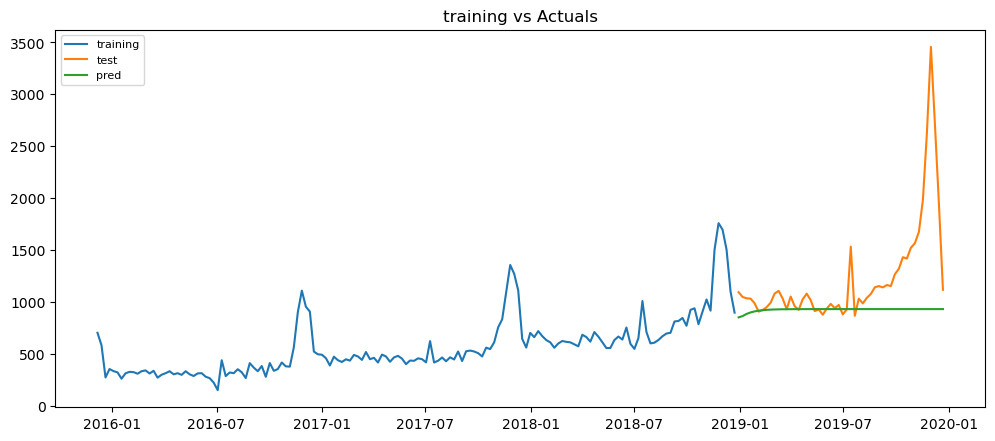

In [72]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(test_data1, label='test')
plt.plot(pred_model, label='pred')
plt.title('training vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

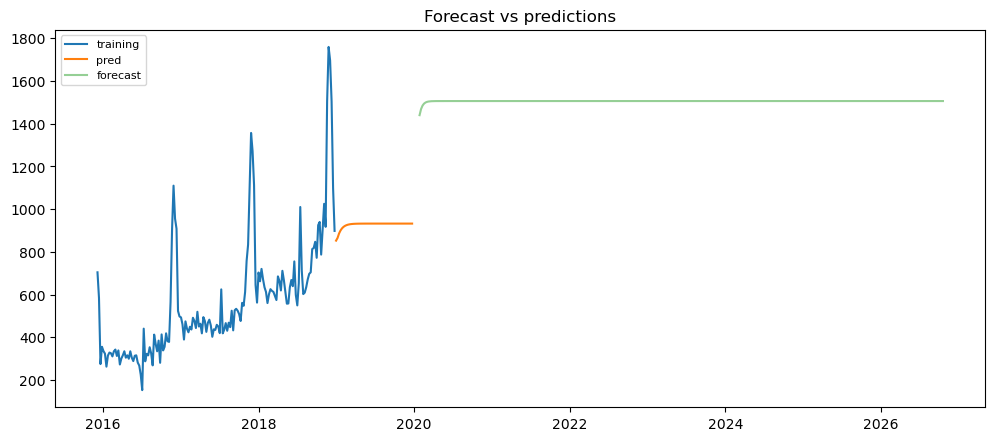

In [73]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(pred_model, label='pred')
plt.plot(forecast, label='forecast', alpha=.5)
#plt.plot(data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['ship_week'], data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['pkgs_num'],
#label ='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Without Differencing 

In [40]:
# #without differencing or transformation 
# model1 = ARIMA(train_data1, order=(1,0,3))
# model_fit1 = model1.fit()
# model_fit1.summary()

In [41]:
#prediction on the test data
# pred_model1 = model_fit1.predict(start=156, end=156+52-1)
# pred_model1.head(10)

## forecasts 

In [42]:
# #forecast
# fcst_data1 = post_code[-3*52:]
# fcst1 = fcst_data1.iloc[:,1]
# fcst1

In [43]:
# model_fct = ARIMA(fcst1, order=(1,0,3))
# model_fct1 = model_fct.fit()
# model_fct1.summary()

In [44]:
# #forecast on the training data
# forecast1 = model_fct1.predict(start=156, end=156+352-1)
# forecast1.head(10)

## Seasonal ARIMA Model

In [78]:
#train
train_data = post_code[-4*212:160]
train_data2 = train_data.iloc[:,1]
train_data2

ship_week
2015-12-06     704
2015-12-13     584
2015-12-20     274
2015-12-27     355
2016-01-03     335
              ... 
2018-11-25    1760
2018-12-02    1697
2018-12-09    1504
2018-12-16    1098
2018-12-23     898
Name: pkgs, Length: 160, dtype: int64

In [70]:
#plot_pacf(train_data2, lags=20)

In [79]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm

In [148]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=52,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=1275.646, Time=11.13 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1300.333, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1280.402, Time=6.34 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1286.134, Time=5.79 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1476.094, Time=0.14 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1274.929, Time=1.63 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=1275.552, Time=11.68 sec
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=14.17 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1284.358, Time=0.85 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1278.981, Time=0.31 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=1274.946, Time=2.46 sec
 ARIMA(1,0,2)(0,1,0)[52] intercept   : AIC=1274.395, Time=2.73 sec
 ARIMA(1,0,2)(1,1,0)[52] intercept   : AIC=1275.658, Time=12.19 sec
 ARIMA(1,0,2)(0,1,1)[52] intercept   : AIC=1275.692, Time=13.71 sec
 ARIMA(1,0,2)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  160
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 52)   Log Likelihood                -633.126
Date:                             Thu, 29 Jul 2021   AIC                           1274.252
Time:                                     22:43:21   BIC                           1284.980
Sample:                                          0   HQIC                          1278.602
                                             - 160                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9978      0.007    137.997      0.000       0.984       1.012
ma.L1         -0.6688      0.111     -6.006      0.000      -0.887      -0.451
ma.L2         -0.1650      0.112     -1.475      0.140      -0.384       0.054
sigma2      7094.7628    660.302     10.745      0.000    5800.595    8388.931
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               242.02
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## US Forecast Parameters

In [76]:
best_model = SARIMAX(train_data2, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  160
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -627.100
Date:                             Fri, 30 Jul 2021   AIC                           1260.200
Time:                                     13:30:16   BIC                           1268.218
Sample:                                 12-06-2015   HQIC                          1263.450
                                      - 12-23-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1785      0.125      1.427      0.153      -0.067       0.424
ma.L1         -0.8644      

## Generated Parameters

In [110]:
#best_model1 = SARIMAX(train_data2, order=(1, 0, 2), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
#print(best_model1.summary())

## Predictions and Forecasting 

In [77]:
pred = best_model.predict(start=160, end=160+52-1)
pred.head(10)

2018-12-30    1041.435059
2019-01-06    1000.869687
2019-01-13    1058.947262
2019-01-20    1010.961109
2019-01-27     972.963580
2019-02-03     950.964021
2019-02-10     898.964100
2019-02-17     939.964114
2019-02-24     963.964116
2019-03-03     955.964117
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [78]:
pred.tail(10)

2019-10-20    1125.964117
2019-10-27    1246.964117
2019-11-03    1363.964117
2019-11-10    1255.964117
2019-11-17    1844.964117
2019-11-24    2098.964117
2019-12-01    2035.964117
2019-12-08    1842.964117
2019-12-15    1436.964117
2019-12-22    1236.964117
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [74]:
#data_pred = pred.to_frame()
#data_pred1 = data_pred.reset_index()
#data_pred1.columns =['ship_week', 'pkgs_num']
#data_pred1.head(10)

## forecasts

In [79]:
#forecast
fcst_data2 = post_code[-3*52:]
fcst2 = fcst_data2.iloc[:,1]
fcst2

ship_week
2017-01-01     493
2017-01-08     460
2017-01-15     389
2017-01-22     474
2017-01-29     440
              ... 
2019-11-24    2632
2019-12-01    3457
2019-12-08    2710
2019-12-15    1942
2019-12-22    1118
Name: pkgs, Length: 156, dtype: int64

In [80]:
best_model_fct = SARIMAX(fcst2, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
print(best_model_fct.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                pkgs   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -669.964
Date:                             Fri, 30 Jul 2021   AIC                           1345.929
Time:                                     13:30:57   BIC                           1353.833
Sample:                                 01-01-2017   HQIC                          1349.130
                                      - 12-22-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4623      0.154      3.000      0.003       0.160       0.764
ma.L1         -0.8949      

In [81]:
fct = best_model_fct.predict(start=160, end=160+352-1)
fct.head(10)

2020-01-26    1604.430182
2020-02-02    1529.026985
2020-02-09    1546.151927
2020-02-16    1575.134213
2020-02-23    1618.588290
2020-03-01    1706.798194
2020-03-08    1732.895225
2020-03-15    1658.940079
2020-03-22    1555.960814
2020-03-29    1677.970399
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [82]:
fct.tail(10)

2026-08-16    5516.850469
2026-08-23    5528.850469
2026-08-30    5515.850469
2026-09-06    5538.850469
2026-09-13    5528.850469
2026-09-20    5642.850469
2026-09-27    5695.850469
2026-10-04    5806.850469
2026-10-11    5793.850469
2026-10-18    5897.850469
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [73]:
#data_fct = fct.to_frame()
#data_fct1 = data_fct.reset_index()
#data_fct1.columns =['ship_week', 'pkgs_num']
#data_fct1.head(10)

In [78]:
#for_v_act= pd.merge(data_fct1,  data_pred1, on=['ship_week'], 
                    #how='inner', suffixes= ('_fct', '_act'))
#for_v_act.head()

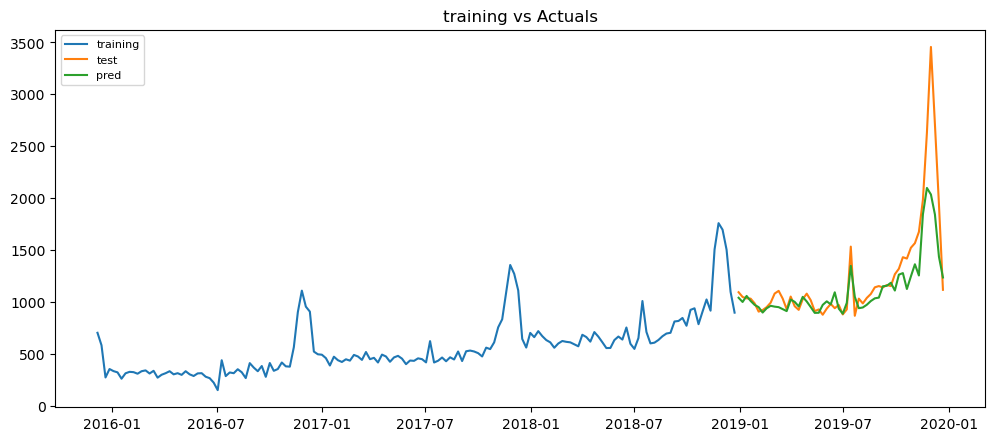

In [83]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(test_data1, label='test')
plt.plot(pred, label='pred')
plt.title('training vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

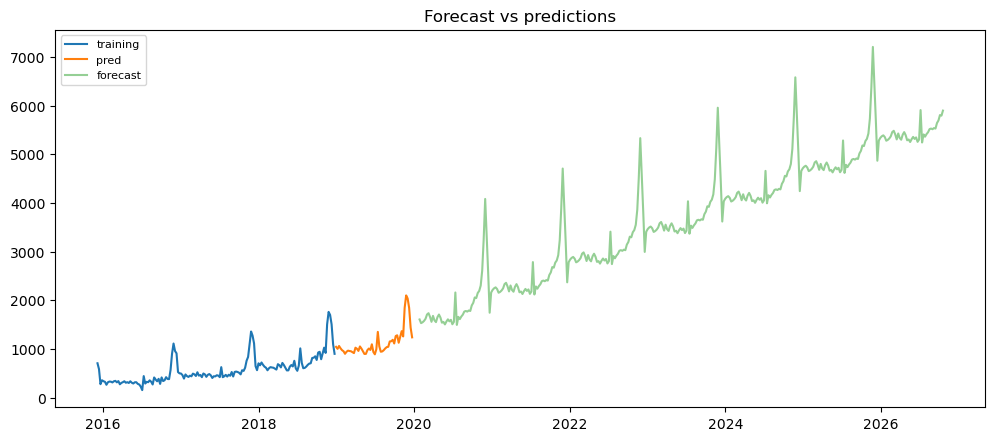

In [84]:
# Plot forecast vs actuals 
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data1, label='training')
plt.plot(pred, label='pred')
plt.plot(fct, label='forecast', alpha=.5)
#plt.plot(data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['ship_week'], data_fct1.loc[(data_fct1.ship_week<'2021-07-01')]['pkgs_num'],
#label ='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs predictions')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Multiprocessing 

In [38]:
# mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
# mod_df

In [80]:
#import modules 
import multiprocessing as mp
from itertools import zip_longest
import time
#from numpy.linalg import LinAlgError

## V1 Version 

In [97]:
# define function 
def run_V1_models(df):
    
    #input from the model 
    
    #df = df.set_index('ship_week')
    train_data = df[-4*212:160]
    test_data = df[-52:]
    fcst_data = df[-3*52:]
    
    
    train_data1 = train_data.iloc[:,1]
    test_data1 = test_data.iloc[:,1]
    fcst = fcst_data.iloc[:,1]
   
    
    #model fit 
    model = ARIMA(train_data1, order=(1,1,3))
    model_fit = model.fit()
    
    
    #predict model
    pred_model = model_fit.predict(start=160, end=160+52-1)
    pred_model = pd.DataFrame(pred_model)
    pred_model.columns= ['pred']
    pred_model['zipcode'] = df['zipcode'].unique()[0]
    
    
    #forecast model
    fct_model = ARIMA(fcst, order=(1,1,3))  
    fct_fit = fct_model.fit()
    
    
    forecast = fct_fit.predict(start=160, end=160+352-1)
    forecast = pd.DataFrame(forecast) 
    forecast.columns = ['pred']
    forecast['zipcode'] = df['zipcode'].unique()[0]
    
    
    
    return pred_model, forecast

#mod = sm.tsa.SARIMAX(y, order=(0 1,0), seasonal_order=(1,0,0,12),enforce_stationarity=False)
#initialization='approximate_diffuse'

In [94]:
#extract R0K from the fxn 
result = run_V1_models(mod_df[mod_df['zipcode']=='R0K'])
# result

## multprocessing on 8 FSA

In [87]:
# eigt_FSA =pd.read_sql (sql, con=con, parse_dates=['ship_week']) #index_col='ship_week')
# eigt_FSA

In [88]:
# df_dict = dict(tuple(eigt_FSA.groupby('zipcode')))

In [90]:
# df_list = [df_dict.get(key) for key in ['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']]

In [91]:
#Initailize
# p = mp.Pool(mp.cpu_count())

In [79]:
#run
# results = p.map(run_V1_models, df_list)
#results[1]

## loop through all FSAs 

In [58]:
# zipcodes = list(mod_df.zipcode.unique())
#len(zipcodes)

In [59]:
#result = []
# predictions=[]
# forecasts=[]

# for zipcode in zipcodes:
#     sub_df = mod_df[mod_df['zipcode']==zipcode]
    
#     pred_model, forecast = run_V1_models(sub_df)
    
#     #result.append([post_code, pred_model, forecast])
#     predictions.append(pred_model)
#     forecasts.append(forecast)

In [81]:
# define function 
def run_V1_models(df):
    
        zipcode = df[0]
        df = df[1]

    
    #input from the model 
        try:
        
    #df = df.set_index('ship_week')
            train_data = df[-4*212:160]
            test_data = df[-52:]
            fcst_data = df[-3*52:]
    
    
            train_data1 = train_data.iloc[:,1]
            test_data1 = test_data.iloc[:,1]
            fcst = fcst_data.iloc[:,1]
        
         #model fit 
            model = ARIMA(train_data1, order=(1,1,3))
            model_fit = model.fit()
            #print(model_fit)
        
        
         #predict model
            pred_model = model_fit.predict(start=160, end=160+52-1)
            pred_model = pd.DataFrame(pred_model)
            pred_model.columns= ['pred']
            pred_model['zipcode'] = df['zipcode'].unique()[0]
           # print(pred_model)
        
         #forecast model
            fct_model = ARIMA(fcst, order=(1,1,3))  
            fct_fit = fct_model.fit()
           # print(fct_fit)
       
            forecast = fct_fit.predict(start=160, end=160+352-1)
            forecast = pd.DataFrame(forecast) 
            forecast.columns = ['pred']
            forecast['zipcode'] = df['zipcode'].unique()[0]
            #print(forecast)
        
           
        except:
            print(df['zipcode'].unique()[0])
            pred_model = np.full(len(test_data1), np.nan)
            pred_model = pd.DataFrame(pred_model)
            pred_model.columns= ['pred']
            pred_model['zipcode'] = df['zipcode'].unique()[0]
            forecast = np.full(len(fcst), np.nan)
            forecast = pd.DataFrame(forecast) 
            forecast.columns = ['pred']
            forecast['zipcode'] = df['zipcode'].unique()[0]
    
        return pred_model, forecast

In [82]:
p = mp.Pool(mp.cpu_count())

J5N
V0Y


In [83]:
results_v1 = p.map(run_V1_models, mod_df.groupby('zipcode'))

In [60]:
# results_v1[0]

In [84]:
predictions=[]
forecasts=[]

for res in results_v1:
    
    pred_model = res[0]
    forecast = res[1]
    
    predictions.append(pred_model)
    forecasts.append(forecast)

In [85]:
predictions[0].head()

pred zipcode
2018-12-30  842.318990     A0A
2019-01-06  842.592264     A0A
2019-01-13  828.629354     A0A
2019-01-20  819.039352     A0A
2019-01-27  812.452749     A0A

In [63]:
forecasts[0].head()

pred zipcode
2020-01-26  1298.095474     A0A
2020-02-02  1311.485731     A0A
2020-02-09  1319.263422     A0A
2020-02-16  1323.781071     A0A
2020-02-23  1326.405134     A0A

In [64]:
type(predictions[0])

pandas.core.frame.DataFrame

In [43]:
type(predictions)

list

In [65]:
len(predictions)

1659

## Predictions

In [66]:
predictions[0].head()

pred zipcode
2018-12-30  842.318990     A0A
2019-01-06  842.592264     A0A
2019-01-13  828.629354     A0A
2019-01-20  819.039352     A0A
2019-01-27  812.452749     A0A

In [67]:
ship_index = predictions[0].reset_index()
ship_index.head()

index        pred zipcode
0 2018-12-30  842.318990     A0A
1 2019-01-06  842.592264     A0A
2 2019-01-13  828.629354     A0A
3 2019-01-20  819.039352     A0A
4 2019-01-27  812.452749     A0A

## Compress list of dataframe into a master dataframe

In [86]:
#get a concertinate format that will work and change the name of the index colunm

df_pred = pd.DataFrame(columns=['index', 'pred', 'zipcode'])
df_pred
for i in range(len(predictions)):
    df_pred = df_pred.append([predictions[i].reset_index()])    
    

In [87]:
df_pred

index         pred zipcode
0   2018-12-30 00:00:00   842.318990     A0A
1   2019-01-06 00:00:00   842.592264     A0A
2   2019-01-13 00:00:00   828.629354     A0A
3   2019-01-20 00:00:00   819.039352     A0A
4   2019-01-27 00:00:00   812.452749     A0A
..                  ...          ...     ...
47  2019-11-24 00:00:00  2031.299260     Y1A
48  2019-12-01 00:00:00  2031.299260     Y1A
49  2019-12-08 00:00:00  2031.299260     Y1A
50  2019-12-15 00:00:00  2031.299260     Y1A
51  2019-12-22 00:00:00  2031.299260     Y1A

[86189 rows x 3 columns]

In [71]:
#HOM
# H0m = df_pred[(df_pred['zipcode'].isin(['H0M']))]
# H0m.head()

In [41]:
dataTypeSeries = df_pred.dtypes
dataTypeSeries

ship_week    datetime64[ns]
pred                float64
zipcode              object
dtype: object

## Convert index column to datetime format & rename to ship_week

In [88]:
df_pred['index'] = pd.to_datetime(df_pred['index'], errors='coerce')
df_pred

index         pred zipcode
0  2018-12-30   842.318990     A0A
1  2019-01-06   842.592264     A0A
2  2019-01-13   828.629354     A0A
3  2019-01-20   819.039352     A0A
4  2019-01-27   812.452749     A0A
..        ...          ...     ...
47 2019-11-24  2031.299260     Y1A
48 2019-12-01  2031.299260     Y1A
49 2019-12-08  2031.299260     Y1A
50 2019-12-15  2031.299260     Y1A
51 2019-12-22  2031.299260     Y1A

[86189 rows x 3 columns]

In [89]:
df_pred.rename({'index': 'ship_week'}, axis=1, inplace=True)
df_pred

ship_week         pred zipcode
0  2018-12-30   842.318990     A0A
1  2019-01-06   842.592264     A0A
2  2019-01-13   828.629354     A0A
3  2019-01-20   819.039352     A0A
4  2019-01-27   812.452749     A0A
..        ...          ...     ...
47 2019-11-24  2031.299260     Y1A
48 2019-12-01  2031.299260     Y1A
49 2019-12-08  2031.299260     Y1A
50 2019-12-15  2031.299260     Y1A
51 2019-12-22  2031.299260     Y1A

[86189 rows x 3 columns]

In [90]:
df_pred_index = df_pred.set_index('ship_week')
df_pred_index

pred zipcode
ship_week                      
2018-12-30   842.318990     A0A
2019-01-06   842.592264     A0A
2019-01-13   828.629354     A0A
2019-01-20   819.039352     A0A
2019-01-27   812.452749     A0A
...                 ...     ...
2019-11-24  2031.299260     Y1A
2019-12-01  2031.299260     Y1A
2019-12-08  2031.299260     Y1A
2019-12-15  2031.299260     Y1A
2019-12-22  2031.299260     Y1A

[86189 rows x 2 columns]

In [53]:
type(df_pred_index)

pandas.core.frame.DataFrame

In [91]:
pred_index = df_pred_index.iloc[:,0]
pred_index

ship_week
2018-12-30     842.318990
2019-01-06     842.592264
2019-01-13     828.629354
2019-01-20     819.039352
2019-01-27     812.452749
                 ...     
2019-11-24    2031.299260
2019-12-01    2031.299260
2019-12-08    2031.299260
2019-12-15    2031.299260
2019-12-22    2031.299260
Name: pred, Length: 86189, dtype: float64

In [55]:
type(pred_index)

pandas.core.series.Series

In [94]:
df_pred.ship_week.max()

Timestamp('2023-08-27 00:00:00')

## Forecast V1

In [78]:
forecasts[1651].head()

pred zipcode
2020-01-26  54.360404     X0B
2020-02-02  54.258741     X0B
2020-02-09  54.314008     X0B
2020-02-16  54.283963     X0B
2020-02-23  54.300297     X0B

In [143]:
df_fct = pd.DataFrame(columns=['index', 'pred', 'zipcode'])
df_fct
for i in range(len(forecasts)):
    df_fct = df_fct.append([forecasts[i].reset_index()])    
    

In [57]:
#df_fct

In [58]:
# df_fct['index'] = pd.to_datetime(df_fct['index'], errors='coerce')
# df_fct

In [59]:
# df_fct.rename({'index': 'ship_week'}, axis=1, inplace=True)
# df_fct.head(10)

In [100]:
df_fct.ship_week.max()

Timestamp('2029-05-27 00:00:00')

## Metrics Calculations & Visuals

In [35]:
# mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
# mod_df

In [92]:
#Actual data
mod_reset = mod_df.reset_index()
mod_reset

ship_week zipcode  pkgs
0      2015-12-06     A0A   655
1      2015-12-06     A0B   314
2      2015-12-06     A0C   195
3      2015-12-06     A0E   403
4      2015-12-06     A0G   544
...           ...     ...   ...
347666 2019-12-22     X0G     4
347667 2019-12-22     X1A  1519
347668 2019-12-22     Y0A    11
347669 2019-12-22     Y0B    34
347670 2019-12-22     Y1A  1997

[347671 rows x 3 columns]

In [80]:
 mod_reset.ship_week.max()

Timestamp('2019-12-22 00:00:00')

## Actauls Vs Forecasts visuals

In [93]:
mod_actual= mod_df[mod_df.index >='2015-12-06']
mod_actual

zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-12-22     X0G     4
2019-12-22     X1A  1519
2019-12-22     Y0A    11
2019-12-22     Y0B    34
2019-12-22     Y1A  1997

[347671 rows x 2 columns]

In [94]:
fsa_act = mod_actual[(mod_actual['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
fsa_act

zipcode  pkgs
ship_week               
2015-12-06     G7Z    24
2015-12-06     G8J    27
2015-12-06     H0M     1
2015-12-06     H3C   709
2015-12-06     K0K  3086
...            ...   ...
2019-12-22     H3C  2270
2019-12-22     K0K  9215
2019-12-22     N0B  7085
2019-12-22     R0K  1118
2019-12-22     V4B  1633

[1666 rows x 2 columns]

In [53]:
# fsa_act = mod_actual[(mod_actual['zipcode'].isin(['H0M']))]
# fsa_act

In [95]:
act_reset = fsa_act.reset_index()
act_reset

ship_week zipcode  pkgs
0    2015-12-06     G7Z    24
1    2015-12-06     G8J    27
2    2015-12-06     H0M     1
3    2015-12-06     H3C   709
4    2015-12-06     K0K  3086
...         ...     ...   ...
1661 2019-12-22     H3C  2270
1662 2019-12-22     K0K  9215
1663 2019-12-22     N0B  7085
1664 2019-12-22     R0K  1118
1665 2019-12-22     V4B  1633

[1666 rows x 3 columns]

In [96]:
mask_rst

NameError: name 'mask_rst' is not defined

In [88]:
mask_pred_act = mask_rst[(mask_rst['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
mask_pred_act

NameError: name 'mask_rst' is not defined

## Absolute pkgs actual VS V1 model

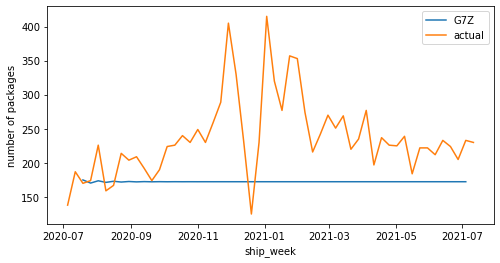

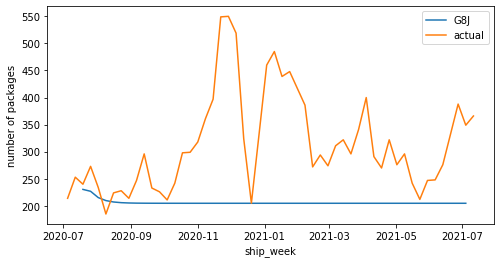

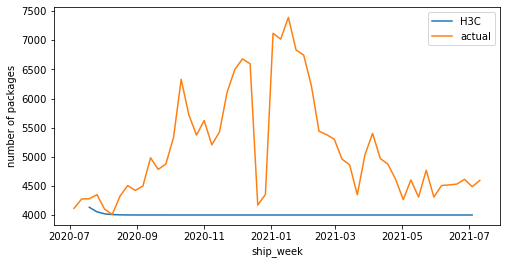

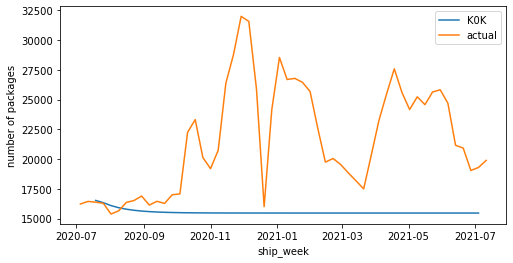

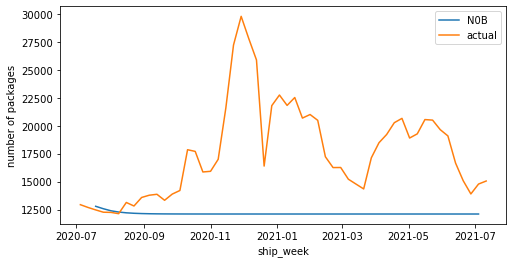

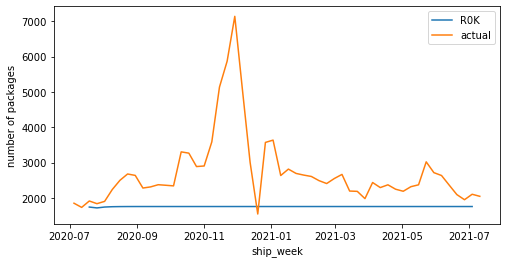

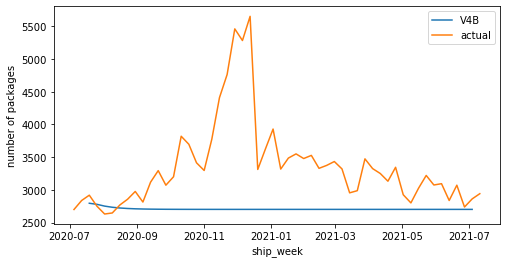

In [372]:
for key, grp in mask_pred_act.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred'], label=key)
    plt.plot(act_reset[act_reset['zipcode']==key]['ship_week'], act_reset[act_reset['zipcode']==key]['pkgs'], label='actual')
    #plt.title('Moving Average (V1) Vs Actaul')
    plt.xlabel('ship_week')
    plt.ylabel('number of packages')
    plt.legend()
    plt.show()

## Proportion visuals for 8FSA

In [109]:
pct_data1

ship_week zipcode      pkgs
0      2015-12-06     A0A  0.068974
1      2015-12-06     A0B  0.033065
2      2015-12-06     A0C  0.020534
3      2015-12-06     A0E  0.042438
4      2015-12-06     A0G  0.057285
...           ...     ...       ...
347666 2019-12-22     X0G  0.000129
347667 2019-12-22     X1A  0.049162
347668 2019-12-22     Y0A  0.000356
347669 2019-12-22     Y0B  0.001100
347670 2019-12-22     Y1A  0.064633

[347671 rows x 3 columns]

In [110]:
pct_data_index = pct_data1.set_index('ship_week')
pct_data_index

zipcode      pkgs
ship_week                   
2015-12-06     A0A  0.068974
2015-12-06     A0B  0.033065
2015-12-06     A0C  0.020534
2015-12-06     A0E  0.042438
2015-12-06     A0G  0.057285
...            ...       ...
2019-12-22     X0G  0.000129
2019-12-22     X1A  0.049162
2019-12-22     Y0A  0.000356
2019-12-22     Y0B  0.001100
2019-12-22     Y1A  0.064633

[347671 rows x 2 columns]

In [111]:
pct_actual= pct_data_index[pct_data_index.index >='2018-12-30']
pct_actual

zipcode      pkgs
ship_week                   
2018-12-30     A0A  0.039666
2018-12-30     A0B  0.020076
2018-12-30     A0C  0.010854
2018-12-30     A0E  0.021885
2018-12-30     A0G  0.036136
...            ...       ...
2019-12-22     X0G  0.000129
2019-12-22     X1A  0.049162
2019-12-22     Y0A  0.000356
2019-12-22     Y0B  0.001100
2019-12-22     Y1A  0.064633

[85774 rows x 2 columns]

In [112]:
pct_act = pct_actual[(pct_actual['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pct_act

zipcode      pkgs
ship_week                   
2018-12-30     G7Z  0.002780
2018-12-30     G8J  0.004236
2018-12-30     H0M  0.000397
2018-12-30     H3C  0.086523
2018-12-30     K0K  0.295000
...            ...       ...
2019-12-22     H3C  0.073468
2019-12-22     K0K  0.298243
2019-12-22     N0B  0.229306
2019-12-22     R0K  0.036184
2019-12-22     V4B  0.052852

[413 rows x 2 columns]

In [113]:
pct_act_reset = pct_act.reset_index()
pct_act_reset

ship_week zipcode      pkgs
0   2018-12-30     G7Z  0.002780
1   2018-12-30     G8J  0.004236
2   2018-12-30     H0M  0.000397
3   2018-12-30     H3C  0.086523
4   2018-12-30     K0K  0.295000
..         ...     ...       ...
408 2019-12-22     H3C  0.073468
409 2019-12-22     K0K  0.298243
410 2019-12-22     N0B  0.229306
411 2019-12-22     R0K  0.036184
412 2019-12-22     V4B  0.052852

[413 rows x 3 columns]

## 8 FSAs actuals

In [114]:
fsa_act = mod_actual[(mod_actual['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
fsa_act

zipcode  pkgs
ship_week               
2017-12-31     G7Z    46
2017-12-31     G8J    49
2017-12-31     H0M     3
2017-12-31     H3C  1240
2017-12-31     K0K  3833
...            ...   ...
2019-12-22     H3C  2270
2019-12-22     K0K  9215
2019-12-22     N0B  7085
2019-12-22     R0K  1118
2019-12-22     V4B  1633

[826 rows x 2 columns]

In [115]:
act_reset = fsa_act.reset_index()
act_reset

ship_week zipcode  pkgs
0   2017-12-31     G7Z    46
1   2017-12-31     G8J    49
2   2017-12-31     H0M     3
3   2017-12-31     H3C  1240
4   2017-12-31     K0K  3833
..         ...     ...   ...
821 2019-12-22     H3C  2270
822 2019-12-22     K0K  9215
823 2019-12-22     N0B  7085
824 2019-12-22     R0K  1118
825 2019-12-22     V4B  1633

[826 rows x 3 columns]

## 8 FSA pred

In [116]:
df_mask_index = df_mask.set_index('ship_week')
df_mask_index

NameError: name 'df_mask' is not defined

In [165]:
mask_rst = df_mask_index.reset_index('ship_week')
mask_rst

ship_week         pred zipcode
0     2020-07-19  1841.832527     A0A
1     2020-07-26  1765.225603     A0A
2     2020-08-02  1724.586639     A0A
3     2020-08-09  1701.911311     A0A
4     2020-08-16  1689.259155     A0A
...          ...          ...     ...
83072 2021-06-06   101.849107     S7C
83073 2021-06-13   101.849107     S7C
83074 2021-06-20   101.849107     S7C
83075 2021-06-27   101.849107     S7C
83076 2021-07-04   101.849107     S7C

[83077 rows x 3 columns]

In [166]:
#% volume distribution/week/FSA for the predictions 
pct_fct1 =mask_rst.groupby(['ship_week','zipcode']).sum()/mask_rst.groupby(['ship_week']).sum()*100
pct_fct1

pred
ship_week  zipcode          
2020-07-19 A0A      0.036357
           A0B      0.017534
           A0C      0.009192
           A0E      0.017971
           A0G      0.031838
...                      ...
2021-07-04 X0E      0.005675
           X1A      0.059896
           Y0A      0.000341
           Y0B      0.001089
           Y1A      0.068067

[83077 rows x 1 columns]

In [169]:
pred_rst = pct_fct1.reset_index()
pred_rst

ship_week zipcode      pred
0     2020-07-19     A0A  0.036357
1     2020-07-19     A0B  0.017534
2     2020-07-19     A0C  0.009192
3     2020-07-19     A0E  0.017971
4     2020-07-19     A0G  0.031838
...          ...     ...       ...
83072 2021-07-04     X0E  0.005675
83073 2021-07-04     X1A  0.059896
83074 2021-07-04     Y0A  0.000341
83075 2021-07-04     Y0B  0.001089
83076 2021-07-04     Y1A  0.068067

[83077 rows x 3 columns]

In [168]:
pred_rst_mask = pred_rst[(pred_rst['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pred_rst_mask

ship_week zipcode      pred
338   2020-07-19     G7Z  0.003454
345   2020-07-19     G8J  0.004549
407   2020-07-19     H3C  0.081628
650   2020-07-19     K0K  0.326194
991   2020-07-19     N0B  0.252803
...          ...     ...       ...
81855 2021-07-04     H3C  0.081462
82098 2021-07-04     K0K  0.314710
82439 2021-07-04     N0B  0.246605
82620 2021-07-04     R0K  0.035870
82956 2021-07-04     V4B  0.054963

[357 rows x 3 columns]

## Actual 8FSA VS V1 proportion visuals

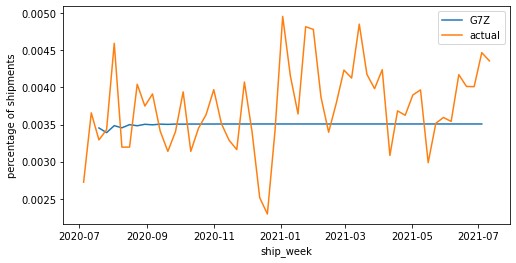

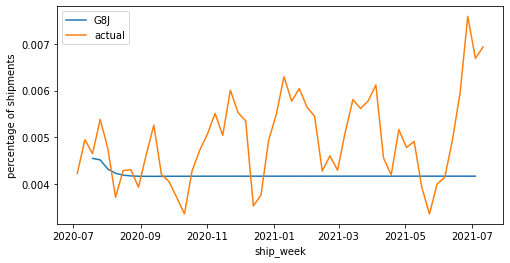

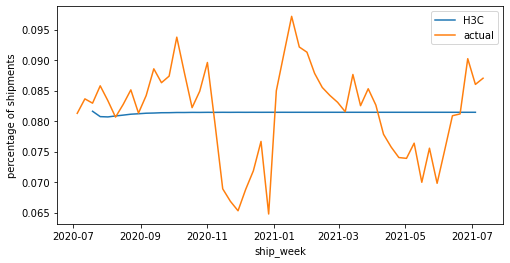

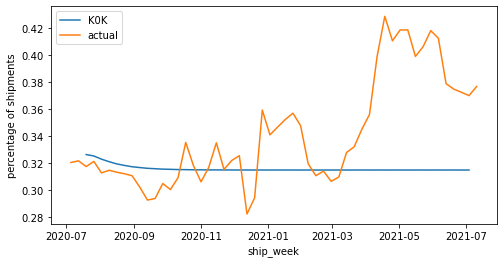

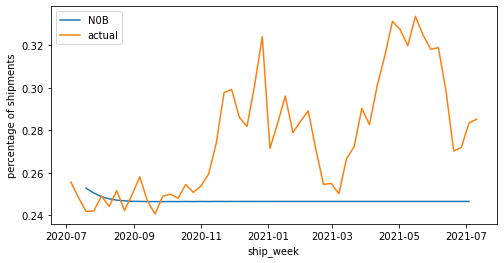

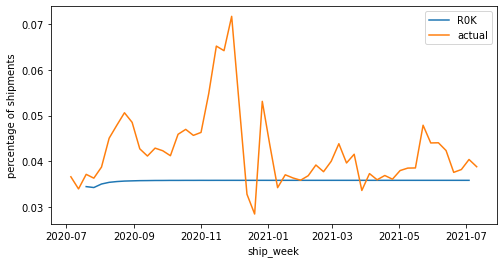

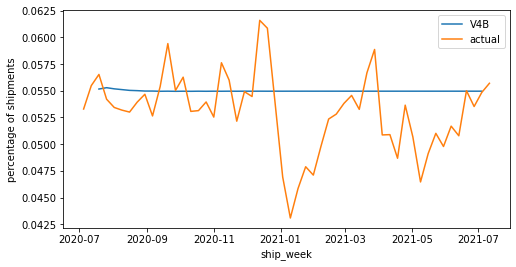

In [172]:
#fig, ax = plt.subplots(figsize=(10,4))
for key, grp in pred_rst_mask.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred'], label=key)
    plt.plot(pct_act_reset[pct_act_reset['zipcode']==key]['ship_week'], pct_act_reset[pct_act_reset['zipcode']==key]['pkgs'], label='actual')
    #plt.title('Moving Average (V1) Vs actual number of pkgs')
    plt.xlabel('ship_week')
    plt.ylabel('percentage of shipments')
    plt.legend()
    plt.show()
    #plt.close()

In [97]:
df_pred

ship_week         pred zipcode
0  2018-12-30   842.318990     A0A
1  2019-01-06   842.592264     A0A
2  2019-01-13   828.629354     A0A
3  2019-01-20   819.039352     A0A
4  2019-01-27   812.452749     A0A
..        ...          ...     ...
47 2019-11-24  2031.299260     Y1A
48 2019-12-01  2031.299260     Y1A
49 2019-12-08  2031.299260     Y1A
50 2019-12-15  2031.299260     Y1A
51 2019-12-22  2031.299260     Y1A

[86189 rows x 3 columns]

In [91]:
len(df_pred.zipcode.unique())

1659

In [93]:
# mask = (df_pred['ship_week'] > '2020-07-05') & (df_pred['ship_week'] <= '2021-07-04')
# print(df_pred.loc[mask])

In [94]:
# df_mask = (df_pred.loc[mask])
# df_mask

In [95]:
# len(df_mask.zipcode.unique())

## Months of Interests

In [193]:
# date_pp_v1 = df_mask[(df_mask['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# date_pp_v1

In [194]:
## v1 forecast for months of interest 
# fsa_pp_v1 = date_pp_v1[(date_pp_v1['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
# fsa_pp_v1

In [195]:
# v1 actual for months of interest 
# act_reset

In [196]:
# act_pp_v1 = act_reset[(act_reset['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# act_pp_v1

In [154]:
# pp_index = act_pp_v1.set_index('ship_week')

In [181]:
# grp1 = pp_index.groupby('zipcode')
# for key in grp1.groups.keys():
#     grp1.get_group(key).plot(title=key)

In [198]:
#fig, ax = plt.subplots(figsize=(10,4))
# # for key, grp in fsa_pp_v1.groupby(['zipcode']):
# #     fig, ax = plt.subplots(figsize=(8,4))
# #     plt.plot(grp['ship_week'], grp['pred'], label=key)
# #     plt.plot(act_pp_v1[act_pp_v1['zipcode']==key]['ship_week'], act_pp_v1[act_pp_v1['zipcode']==key]['pkgs'], label='actual')
# #     plt.legend()
#     plt.show()
#     #plt.close()

In [199]:
# sort_df = df_mask.sort_values('ship_week')
# sort_df

In [99]:
# sort_df.dtypes

In [96]:
# df_mask_index = df_mask.set_index('ship_week')
# df_mask_index

In [97]:
# df_mask_index.dtypes

In [98]:
# pred_mask.dtypes

## Metrics V1

In [98]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

ship_week zipcode      pkgs
0 2015-12-06     A0A  0.000690
1 2015-12-06     A0B  0.000331
2 2015-12-06     A0C  0.000205
3 2015-12-06     A0E  0.000424
4 2015-12-06     A0G  0.000573
5 2015-12-06     A0H  0.000320
6 2015-12-06     A0J  0.000187
7 2015-12-06     A0K  0.000325
8 2015-12-06     A0L  0.000194
9 2015-12-06     A0M  0.000145

In [118]:
len(pct_data2.zipcode.unique())

1659

In [121]:
df_pred

ship_week         pred zipcode
0  2018-12-30   842.318990     A0A
1  2019-01-06   842.592264     A0A
2  2019-01-13   828.629354     A0A
3  2019-01-20   819.039352     A0A
4  2019-01-27   812.452749     A0A
..        ...          ...     ...
47 2019-11-24  2031.299260     Y1A
48 2019-12-01  2031.299260     Y1A
49 2019-12-08  2031.299260     Y1A
50 2019-12-15  2031.299260     Y1A
51 2019-12-22  2031.299260     Y1A

[86189 rows x 3 columns]

In [120]:
# prop_df_pred = df_pred.groupby(['ship_week','zipcode']).sum()/df_pred.groupby(['ship_week']).sum()
# prop_df_pred

In [119]:
# df_mask_index = df_mask.set_index('ship_week')
# df_mask_index

In [120]:
# len(df_mask_index.zipcode.unique())

In [99]:
prop = df_pred.groupby(['ship_week','zipcode']).sum()/df_pred.groupby(['ship_week']).sum()
prop

pred
ship_week  zipcode          
2018-12-30 A0A      0.000411
           A0B      0.000195
           A0C      0.000101
           A0E      0.000223
           A0G      0.000438
...                      ...
2023-08-20 R5P      0.204071
           R5R      0.572774
           R5T      0.223155
2023-08-27 R5P      0.262692
           R5R      0.737308

[84656 rows x 1 columns]

In [100]:
prop_rst = prop.reset_index()

In [101]:
mask = (prop_rst['ship_week'] > '2018-12-04') & (prop_rst['ship_week'] <= '2019-12-22')
print(prop_rst.loc[mask])

       ship_week zipcode      pred
0     2018-12-30     A0A  0.000411
1     2018-12-30     A0B  0.000195
2     2018-12-30     A0C  0.000101
3     2018-12-30     A0E  0.000223
4     2018-12-30     A0G  0.000438
...          ...     ...       ...
84183 2019-12-22     X0E  0.000042
84184 2019-12-22     X1A  0.000725
84185 2019-12-22     Y0A  0.000003
84186 2019-12-22     Y0B  0.000015
84187 2019-12-22     Y1A  0.000920

[84188 rows x 3 columns]


In [102]:
prop_reset = prop_rst.loc[mask]
prop_reset

ship_week zipcode      pred
0     2018-12-30     A0A  0.000411
1     2018-12-30     A0B  0.000195
2     2018-12-30     A0C  0.000101
3     2018-12-30     A0E  0.000223
4     2018-12-30     A0G  0.000438
...          ...     ...       ...
84183 2019-12-22     X0E  0.000042
84184 2019-12-22     X1A  0.000725
84185 2019-12-22     Y0A  0.000003
84186 2019-12-22     Y0B  0.000015
84187 2019-12-22     Y1A  0.000920

[84188 rows x 3 columns]

In [103]:
prop_mean= prop_reset.groupby(['zipcode'], sort=False).mean()
prop_mean

pred
zipcode          
A0A      0.000365
A0B      0.000178
A0C      0.000091
A0E      0.000193
A0G      0.000389
...           ...
X0E      0.000042
X1A      0.000724
Y0A      0.000003
Y0B      0.000015
Y1A      0.000920

[1619 rows x 1 columns]

In [104]:
prop_mean_rst = prop_mean.reset_index()
prop_mean_rst

zipcode      pred
0        A0A  0.000365
1        A0B  0.000178
2        A0C  0.000091
3        A0E  0.000193
4        A0G  0.000389
...      ...       ...
1614     X0E  0.000042
1615     X1A  0.000724
1616     Y0A  0.000003
1617     Y0B  0.000015
1618     Y1A  0.000920

[1619 rows x 2 columns]

In [106]:
result_prop_v1 = pd.merge(prop_mean_rst, pct_data2,  on=["zipcode"])
result_prop_v1

zipcode      pred  ship_week      pkgs
0          A0A  0.000365 2015-12-06  0.000690
1          A0A  0.000365 2015-12-13  0.000433
2          A0A  0.000365 2015-12-20  0.000310
3          A0A  0.000365 2015-12-27  0.000518
4          A0A  0.000365 2016-01-03  0.000508
...        ...       ...        ...       ...
343223     Y1A  0.000920 2019-11-24  0.000920
343224     Y1A  0.000920 2019-12-01  0.001067
343225     Y1A  0.000920 2019-12-08  0.000857
343226     Y1A  0.000920 2019-12-15  0.000527
343227     Y1A  0.000920 2019-12-22  0.000646

[343228 rows x 4 columns]

In [107]:
result_prop_v1['diff_mix'] =result_prop_v1['pkgs'] - result_prop_v1['pred']

result_prop_v1['diff_mix']= result_prop_v1['diff_mix'].abs()

result_prop_v1

zipcode      pred  ship_week      pkgs      diff_mix
0          A0A  0.000365 2015-12-06  0.000690  3.247482e-04
1          A0A  0.000365 2015-12-13  0.000433  6.802177e-05
2          A0A  0.000365 2015-12-20  0.000310  5.513118e-05
3          A0A  0.000365 2015-12-27  0.000518  1.531164e-04
4          A0A  0.000365 2016-01-03  0.000508  1.432364e-04
...        ...       ...        ...       ...           ...
343223     Y1A  0.000920 2019-11-24  0.000920  7.013718e-08
343224     Y1A  0.000920 2019-12-01  0.001067  1.469572e-04
343225     Y1A  0.000920 2019-12-08  0.000857  6.263530e-05
343226     Y1A  0.000920 2019-12-15  0.000527  3.932342e-04
343227     Y1A  0.000920 2019-12-22  0.000646  2.736387e-04

[343228 rows x 5 columns]

In [108]:
result_prop_v1['APE'] = result_prop_v1['diff_mix'] / result_prop_v1['pkgs']
result_prop_v1

zipcode      pred  ship_week      pkgs      diff_mix       APE
0          A0A  0.000365 2015-12-06  0.000690  3.247482e-04  0.470826
1          A0A  0.000365 2015-12-13  0.000433  6.802177e-05  0.157089
2          A0A  0.000365 2015-12-20  0.000310  5.513118e-05  0.177922
3          A0A  0.000365 2015-12-27  0.000518  1.531164e-04  0.295529
4          A0A  0.000365 2016-01-03  0.000508  1.432364e-04  0.281834
...        ...       ...        ...       ...           ...       ...
343223     Y1A  0.000920 2019-11-24  0.000920  7.013718e-08  0.000076
343224     Y1A  0.000920 2019-12-01  0.001067  1.469572e-04  0.137739
343225     Y1A  0.000920 2019-12-08  0.000857  6.263530e-05  0.073058
343226     Y1A  0.000920 2019-12-15  0.000527  3.932342e-04  0.746553
343227     Y1A  0.000920 2019-12-22  0.000646  2.736387e-04  0.423374

[343228 rows x 6 columns]

In [109]:
#MAPE
mean_v1= result_prop_v1.groupby(['ship_week'])[['APE']].mean()*100
mean_v1

APE
ship_week            
2015-12-06  30.870731
2015-12-13  28.602180
2015-12-20  25.997731
2015-12-27  22.979943
2016-01-03  25.145884
...               ...
2019-11-24  18.903316
2019-12-01  20.925576
2019-12-08  21.108174
2019-12-15  20.422369
2019-12-22  20.836794

[212 rows x 1 columns]

In [110]:
mape_v1_upd = mean_v1[mean_v1.index >'2018-12-04']
mape_v1_upd

APE
ship_week            
2018-12-09  15.386762
2018-12-16  15.907644
2018-12-23  11.345239
2018-12-30  11.243636
2019-01-06  10.620729
2019-01-13  10.257647
2019-01-20  10.505274
2019-01-27  10.458270
2019-02-03  10.435632
2019-02-10  10.872699
2019-02-17   9.666120
2019-02-24  10.500341
2019-03-03  10.911662
2019-03-10  11.324698
2019-03-17  11.273789
2019-03-24  11.561698
2019-03-31  11.519103
2019-04-07  11.583070
2019-04-14  12.450581
2019-04-21  11.158596
2019-04-28  11.830727
2019-05-05  11.493221
2019-05-12  11.125770
2019-05-19  11.679009
2019-05-26  11.178970
2019-06-02  11.690998
2019-06-09  11.801604
2019-06-16  11.778548
2019-06-23  12.453942
2019-06-30  12.238866
2019-07-07  11.968712
2019-07-14  13.545533
2019-07-21  11.831932
2019-07-28  12.102213
2019-08-04  13.332570
2019-08-11  12.490960
2019-08-18  13.104487
2019-08-25  12.735455
2019-09-01  13.454679
2019-09-08  12.390462
2019-09-15  12.297031
2019-09-22  12.564371
2019-09-29  13.658285
2019-10-06  12.837252
2019-10-13  13.980394
2019-10-20  13.344235
2019-10-27  13.860046
2019-11-03  14.578878
2019-11-10  15.931665
2019-11-17  18.564619
2019-11-24  18.903316
2019-12-01  20.925576
2019-12-08  21.108174
2019-12-15  20.422369
2019-12-22  20.836794

In [111]:
def my_agg(x):
    names = {'weighted_v1_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v1_mix'])

In [112]:
wegt_v1 = result_prop_v1.groupby(["ship_week"]).apply(my_agg)*100
wegt_v1

weighted_v1_mix
ship_week                  
2015-12-06        27.991979
2015-12-13        24.517922
2015-12-20        19.233273
2015-12-27        18.485018
2016-01-03        21.353891
...                     ...
2019-11-24        18.643391
2019-12-01        20.903681
2019-12-08        21.063074
2019-12-15        18.253755
2019-12-22        14.993859

[212 rows x 1 columns]

In [113]:
wape_v1_upd = wegt_v1[wegt_v1.index >'2018-12-04']
wape_v1_upd

weighted_v1_mix
ship_week                  
2018-12-09        14.887733
2018-12-16        13.020631
2018-12-23         8.640115
2018-12-30         9.824262
2019-01-06        10.195840
2019-01-13         9.602587
2019-01-20         9.321879
2019-01-27         9.745577
2019-02-03         9.178109
2019-02-10         9.674085
2019-02-17         8.463374
2019-02-24         9.147839
2019-03-03         9.701888
2019-03-10        10.562963
2019-03-17        10.191069
2019-03-24        10.652553
2019-03-31        10.401837
2019-04-07        10.659998
2019-04-14        11.613207
2019-04-21         9.570139
2019-04-28        10.919286
2019-05-05        10.737680
2019-05-12        10.000641
2019-05-19        10.786244
2019-05-26        10.134495
2019-06-02        10.636303
2019-06-09        11.279121
2019-06-16        10.630793
2019-06-23        11.195250
2019-06-30        10.788352
2019-07-07        10.749373
2019-07-14        11.970505
2019-07-21        10.136326
2019-07-28        10.882034
2019-08-04        12.058502
2019-08-11        11.498303
2019-08-18        11.932639
2019-08-25        11.639351
2019-09-01        12.694628
2019-09-08        11.695895
2019-09-15        11.260436
2019-09-22        11.605632
2019-09-29        12.848148
2019-10-06        12.234769
2019-10-13        12.781914
2019-10-20        12.327749
2019-10-27        13.211987
2019-11-03        14.190839
2019-11-10        14.894430
2019-11-17        18.119257
2019-11-24        18.643391
2019-12-01        20.903681
2019-12-08        21.063074
2019-12-15        18.253755
2019-12-22        14.993859

## without Mean

In [114]:
result_metric_prop = pd.merge(pct_data2, prop_reset, on=["ship_week", "zipcode"])
result_metric_prop

ship_week zipcode      pkgs      pred
0     2018-12-30     A0A  0.000397  0.000411
1     2018-12-30     A0B  0.000201  0.000195
2     2018-12-30     A0C  0.000109  0.000101
3     2018-12-30     A0E  0.000219  0.000223
4     2018-12-30     A0G  0.000361  0.000438
...          ...     ...       ...       ...
84183 2019-12-22     X0E  0.000047  0.000042
84184 2019-12-22     X1A  0.000492  0.000725
84185 2019-12-22     Y0A  0.000004  0.000003
84186 2019-12-22     Y0B  0.000011  0.000015
84187 2019-12-22     Y1A  0.000646  0.000920

[84188 rows x 4 columns]

In [116]:
#take the difference
result_metric_prop['diff_mix'] = result_metric_prop['pkgs'] - result_metric_prop['pred']

result_metric_prop['diff_mix']= result_metric_prop['diff_mix'].abs()

result_metric_prop

ship_week zipcode      pkgs      pred      diff_mix
0     2018-12-30     A0A  0.000397  0.000411  1.384448e-05
1     2018-12-30     A0B  0.000201  0.000195  5.986371e-06
2     2018-12-30     A0C  0.000109  0.000101  7.389377e-06
3     2018-12-30     A0E  0.000219  0.000223  3.911672e-06
4     2018-12-30     A0G  0.000361  0.000438  7.638813e-05
...          ...     ...       ...       ...           ...
84183 2019-12-22     X0E  0.000047  0.000042  4.636453e-06
84184 2019-12-22     X1A  0.000492  0.000725  2.332256e-04
84185 2019-12-22     Y0A  0.000004  0.000003  4.436096e-07
84186 2019-12-22     Y0B  0.000011  0.000015  4.247752e-06
84187 2019-12-22     Y1A  0.000646  0.000920  2.732774e-04

[84188 rows x 5 columns]

In [117]:
len(result_metric_prop.zipcode.unique())

1619

In [118]:
result_metric_prop['APE'] = result_metric_prop['diff_mix'] / result_metric_prop['pkgs']
result_metric_prop

ship_week zipcode      pkgs      pred      diff_mix       APE
0     2018-12-30     A0A  0.000397  0.000411  1.384448e-05  0.034903
1     2018-12-30     A0B  0.000201  0.000195  5.986371e-06  0.029819
2     2018-12-30     A0C  0.000109  0.000101  7.389377e-06  0.068080
3     2018-12-30     A0E  0.000219  0.000223  3.911672e-06  0.017874
4     2018-12-30     A0G  0.000361  0.000438  7.638813e-05  0.211391
...          ...     ...       ...       ...           ...       ...
84183 2019-12-22     X0E  0.000047  0.000042  4.636453e-06  0.099483
84184 2019-12-22     X1A  0.000492  0.000725  2.332256e-04  0.474399
84185 2019-12-22     Y0A  0.000004  0.000003  4.436096e-07  0.124604
84186 2019-12-22     Y0B  0.000011  0.000015  4.247752e-06  0.386016
84187 2019-12-22     Y1A  0.000646  0.000920  2.732774e-04  0.422815

[84188 rows x 6 columns]

In [119]:
len(result_metric_prop.zipcode.unique())

1619

## check the FSAs with high errors 

In [134]:
# res = result_metric_prop.sort_values('APE', ascending=False)
# res

In [135]:
# mean_error = res.groupby(['zipcode'])[['APE']].mean()

# mean_error

In [136]:
# mean_error.sort_values('APE', ascending=False)

## MAPE V1

In [120]:
#MAPE
mean_result_prop= result_metric_prop.groupby(['ship_week'])[['APE']].mean()*100
mean_result_prop

APE
ship_week            
2018-12-30  15.106490
2019-01-06  16.266600
2019-01-13  13.440775
2019-01-20  12.245041
2019-01-27  11.738414
2019-02-03  10.957848
2019-02-10  11.360737
2019-02-17   9.732525
2019-02-24  10.637723
2019-03-03  10.761608
2019-03-10  11.284303
2019-03-17  11.023850
2019-03-24  11.431817
2019-03-31  11.268271
2019-04-07  11.332247
2019-04-14  12.192639
2019-04-21  10.957722
2019-04-28  11.531975
2019-05-05  11.262845
2019-05-12  10.805107
2019-05-19  11.488683
2019-05-26  10.858242
2019-06-02  11.441225
2019-06-09  11.454814
2019-06-16  11.553576
2019-06-23  12.098217
2019-06-30  12.070487
2019-07-07  11.652525
2019-07-14  13.351763
2019-07-21  11.575884
2019-07-28  11.872841
2019-08-04  13.110780
2019-08-11  12.271716
2019-08-18  12.775818
2019-08-25  12.498441
2019-09-01  13.159213
2019-09-08  12.141491
2019-09-15  11.996800
2019-09-22  12.301542
2019-09-29  13.316070
2019-10-06  12.568416
2019-10-13  13.682586
2019-10-20  13.079369
2019-10-27  13.523598
2019-11-03  14.309079
2019-11-10  15.661161
2019-11-17  18.326069
2019-11-24  18.640767
2019-12-01  20.684569
2019-12-08  20.858024
2019-12-15  20.186438
2019-12-22  21.053937

In [121]:
mape_pp_v1 = mean_result_prop.reset_index()
mape_pp_v1.head()

ship_week        APE
0 2018-12-30  15.106490
1 2019-01-06  16.266600
2 2019-01-13  13.440775
3 2019-01-20  12.245041
4 2019-01-27  11.738414

In [285]:
# mape_pp_v1 = mean_result_prop.reset_index()

In [287]:
# mape_pp_v1 = mape_pp_v1[(mape_pp_v1['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# mape_pp_v1

## WAPE V1

In [122]:
def my_agg(x):
    names = {'weighted_avg_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_avg_mix'])

In [123]:
wape_V1 = result_metric_prop.groupby(["ship_week"]).apply(my_agg)*100
wape_V1

weighted_avg_mix
ship_week                   
2018-12-30         13.691692
2019-01-06         16.078356
2019-01-13         12.723959
2019-01-20         11.103367
2019-01-27         10.994400
2019-02-03          9.701934
2019-02-10         10.105353
2019-02-17          8.559191
2019-02-24          9.231423
2019-03-03          9.548906
2019-03-10         10.480955
2019-03-17          9.951231
2019-03-24         10.465316
2019-03-31         10.153861
2019-04-07         10.367903
2019-04-14         11.369603
2019-04-21          9.326561
2019-04-28         10.627714
2019-05-05         10.462629
2019-05-12          9.675476
2019-05-19         10.544060
2019-05-26          9.802199
2019-06-02         10.359132
2019-06-09         10.938088
2019-06-16         10.372509
2019-06-23         10.832271
2019-06-30         10.587542
2019-07-07         10.441948
2019-07-14         11.771620
2019-07-21          9.886705
2019-07-28         10.635911
2019-08-04         11.817777
2019-08-11         11.251790
2019-08-18         11.619960
2019-08-25         11.375017
2019-09-01         12.385562
2019-09-08         11.394622
2019-09-15         10.936093
2019-09-22         11.321183
2019-09-29         12.483683
2019-10-06         11.936332
2019-10-13         12.469267
2019-10-20         12.029583
2019-10-27         12.858653
2019-11-03         13.901473
2019-11-10         14.598826
2019-11-17         17.840498
2019-11-24         18.348397
2019-12-01         20.614614
2019-12-08         20.790875
2019-12-15         18.014173
2019-12-22         15.124720

In [138]:
# wape_pp_v1 = wape_V1.reset_index()

In [288]:
# wape_pp_v1 = wape_pp_v1[(wape_pp_v1['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# wape_pp_v1

In [89]:
wape_V1.dtypes

weighted_avg_mix    float64
dtype: object

## Multiprocessing for all FSAs 

In [56]:
# mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
# mod_df

In [58]:
#mod_df['ship_week'] = pd.to_datetime(mod_df['ship_week'])

In [166]:
#  mod_df = mod_df[((mod_df['ship_week']).dt.day != 1) |
#                  ((mod_df['ship_week']).dt.month != 1)]

In [45]:
mod_df.shape

(348432, 2)

In [68]:
num_fsa = int(len(mod_df.zipcode.unique()) / mp.cpu_count()) + 1

In [69]:
num_fsa

207

In [63]:
grp_fsa = list(zip_longest(*(iter(pd.unique(mod_df['zipcode'])),) * num_fsa))
#grp_fsa

In [88]:
pd.unique(mod_df['zipcode'])

(1652,)

In [64]:
df_dict = dict(tuple(mod_df.groupby('zipcode')))
#df_dict

In [65]:
# fsa_list = [pd.concat([df_dict.get(key) for key in mod_df]) for mod_df in grp_fsa]
# #fsa_list
fsa_list = [pd.concat([df_dict.get(key) for key in y]) for y in grp_fsa]
#fsa_list

In [66]:
p = mp.Pool(mp.cpu_count())

In [70]:
# results = p.map(run_V1_models, fsa_list)......error

## V2 Version 

In [234]:
# # define function 
# def run_V2_models(df):
    
#     #input from the model 
    
#     #df = df.set_index('ship_week')
#     train_data = df[-4*212:160]
#     test_data = df[-52:]
#     fcst_data = df[-3*52:]
    
    
#     train_data1 = train_data.iloc[:,1]
#     test_data1 = test_data.iloc[:,1]
#     fcst = fcst_data.iloc[:,1]
    
#     best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
#     pred = best_model.predict(start=160, end=160+52-1)
#     pred = pd.DataFrame(pred)
#     pred.columns= ['pred_V2']
#     pred['zipcode'] = df['zipcode'].unique()[0]
    
    
#     best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
#     fct = best_model_fct.predict(start=160, end=160+352-1)
#     fct = pd.DataFrame(fct) 
#     fct.columns = ['pred_V2']
#     fct['zipcode'] = df['zipcode'].unique()[0]
    
#     return pred, fct
   

In [ ]:
#Tunning 
#(2,0,0) (0,1,1)52.......cannnot run this 
#(0,1,1) (0,1,1)52
#(0,1,1) (0,1,0)52

In [80]:
# zipcodes = list(mod_df.zipcode.unique())
# len(zipcodes)

1653

In [81]:
# predictions2=[]
# forecasts2=[]

# for zipcode in zipcodes:
#     sub_df = mod_df[mod_df['zipcode']==zipcode]
    
#     pred, fct = run_V2_models(sub_df)
    
#     #result.append([post_code, pred_model, forecast])
#     predictions2.append(pred)
#     forecasts2.append(fct)

In [168]:
# forecasts2[0]

In [169]:
# predictions2[0].head()

In [124]:
# define function 
def run_V2_models(df):
    
    zipcode = df[0]
    df = df[1]

    
    #input from the model 
    try:
        
    #df = df.set_index('ship_week')
        train_data = df[-4*212:160]
        test_data = df[-52:]
        fcst_data = df[-3*52:]
    
    
        train_data1 = train_data.iloc[:,1]
        test_data1 = test_data.iloc[:,1]
        fcst = fcst_data.iloc[:,1]
    
        best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
        pred = best_model.predict(start=160, end=160+52-1)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
    
    
        best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        fct = best_model_fct.predict(start=160, end=160+352-1)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    
    except:
        print(df['zipcode'].unique()[0])
        pred = np.full(len(test_data1), np.nan)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
        fct = np.full(len(fcst), np.nan)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    return pred, fct

In [125]:
 p = mp.Pool(mp.cpu_count())

T3T


In [126]:
results = p.map(run_V2_models, mod_df.groupby('zipcode'))

In [170]:
# results[0]

In [127]:
results_pred=[]
results_fct=[]

for res in results:
    
    pred = res[0]
    fct = res[1]
    
    results_pred.append(pred)
    results_fct.append(fct)

In [173]:
# results_pred[0]

## V2 Metrics

In [128]:
#get a concertinate format that will work and change the name of the index colunm

pred_V2 = pd.DataFrame(columns=['index', 'pred_V2', 'zipcode'])
pred_V2
for i in range(len(results_pred)):
    pred_V2 = pred_V2.append([results_pred[i].reset_index()])    
    

In [23]:
#pred_V2

In [129]:
pred_V2['index'] = pd.to_datetime(pred_V2['index'], errors='coerce')
pred_V2

index      pred_V2 zipcode
0  2018-12-30   838.207536     A0A
1  2019-01-06   797.408691     A0A
2  2019-01-13   788.240430     A0A
3  2019-01-20   774.168399     A0A
4  2019-01-27   804.569466     A0A
..        ...          ...     ...
47 2019-11-24  3747.578893     Y1A
48 2019-12-01  3531.578893     Y1A
49 2019-12-08  3408.578893     Y1A
50 2019-12-15  2678.578893     Y1A
51 2019-12-22  2517.578893     Y1A

[86268 rows x 3 columns]

In [131]:
pred_V2.rename({'index': 'ship_week'}, axis=1, inplace=True)
pred_V2.head(10)

ship_week     pred_V2 zipcode
0 2018-12-30  838.207536     A0A
1 2019-01-06  797.408691     A0A
2 2019-01-13  788.240430     A0A
3 2019-01-20  774.168399     A0A
4 2019-01-27  804.569466     A0A
5 2019-02-03  756.396341     A0A
6 2019-02-10  731.346298     A0A
7 2019-02-17  698.331832     A0A
8 2019-02-24  783.327651     A0A
9 2019-03-03  766.326442     A0A

In [132]:
v2_mask_index = pred_V2.set_index('ship_week')
v2_mask_index

pred_V2 zipcode
ship_week                      
2018-12-30   838.207536     A0A
2019-01-06   797.408691     A0A
2019-01-13   788.240430     A0A
2019-01-20   774.168399     A0A
2019-01-27   804.569466     A0A
...                 ...     ...
2019-11-24  3747.578893     Y1A
2019-12-01  3531.578893     Y1A
2019-12-08  3408.578893     Y1A
2019-12-15  2678.578893     Y1A
2019-12-22  2517.578893     Y1A

[86268 rows x 2 columns]

In [133]:
prop_v2 = v2_mask_index.groupby(['ship_week','zipcode']).sum()/v2_mask_index.groupby(['ship_week']).sum()*100
prop_v2

pred_V2
ship_week  zipcode           
2018-12-30 A0A       0.034382
           A0B       0.015540
           A0C       0.008179
           A0E       0.015965
           A0G       0.031791
...                       ...
2023-08-20 R5P      20.454545
           R5R      52.892564
           R5T      26.652891
2023-08-27 R5P      26.589594
           R5R      73.410406

[84656 rows x 1 columns]

In [134]:
prop_v2_reset = prop_v2.reset_index()
prop_v2_reset

ship_week zipcode    pred_V2
0     2018-12-30     A0A   0.034382
1     2018-12-30     A0B   0.015540
2     2018-12-30     A0C   0.008179
3     2018-12-30     A0E   0.015965
4     2018-12-30     A0G   0.031791
...          ...     ...        ...
84651 2023-08-20     R5P  20.454545
84652 2023-08-20     R5R  52.892564
84653 2023-08-20     R5T  26.652891
84654 2023-08-27     R5P  26.589594
84655 2023-08-27     R5R  73.410406

[84656 rows x 3 columns]

In [135]:
## v2 actuals for 8 FSA
pred_rst_v2 = prop_v2_reset[(prop_v2_reset['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
pred_rst_v2

ship_week zipcode   pred_V2
334   2018-12-30     G7Z  0.002845
341   2018-12-30     G8J  0.003744
403   2018-12-30     H3C  0.084781
647   2018-12-30     K0K  0.285427
985   2018-12-30     N0B  0.210991
...          ...     ...       ...
82972 2019-12-22     H3C  0.073501
83216 2019-12-22     K0K  0.314570
83554 2019-12-22     N0B  0.217763
83735 2019-12-22     R0K  0.042202
84067 2019-12-22     V4B  0.047446

[364 rows x 3 columns]

In [162]:
pct_act_reset

NameError: name 'pct_act_reset' is not defined

## V2 Visuals....actual vs forecasts 

In [180]:
#fig, ax = plt.subplots(figsize=(10,4))
# for key, grp in pred_rst_v2.groupby(['zipcode']):
#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
#     plt.plot(pct_act_reset[pct_act_reset['zipcode']==key]['ship_week'], pct_act_reset[pct_act_reset['zipcode']==key]['pkgs'], label='actual')
#     #plt.title('V2 Model Version and Actual pkgs')
#     plt.xlabel ('ship_week')
#     plt.ylabel ('percentage of shipments')
#     plt.legend()
#     plt.show()
#     #plt.close()

## Absolute VS V2 Visuals

In [237]:
#actualu
act_reset

ship_week zipcode   pkgs
0   2020-07-05     G7Z    138
1   2020-07-05     G8J    214
2   2020-07-05     H0M     20
3   2020-07-05     H3C   4117
4   2020-07-05     K0K  16222
..         ...     ...    ...
427 2021-07-11     H3C   4596
428 2021-07-11     K0K  19891
429 2021-07-11     N0B  15065
430 2021-07-11     R0K   2051
431 2021-07-11     V4B   2941

[432 rows x 3 columns]

In [238]:
#forecast
v2_index = v2_mask_index.reset_index()
v2_index

ship_week      pred_V2 zipcode
0     2020-07-19  1386.472752     A0A
1     2020-07-26  1263.307550     A0A
2     2020-08-02  1430.264873     A0A
3     2020-08-09  1418.986253     A0A
4     2020-08-16  1452.327222     A0A
...          ...          ...     ...
85951 2023-07-30   360.810531     R5R
85952 2023-08-06   375.965734     R5R
85953 2023-08-13   357.022420     R5R
85954 2023-08-20   391.043124     R5R
85955 2023-08-27   427.050686     R5R

[85956 rows x 3 columns]

In [239]:
fsa_v2 = v2_index[(v2_index['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
fsa_v2

ship_week      pred_V2 zipcode
17576 2020-07-19   151.212898     G7Z
17577 2020-07-26   176.894731     G7Z
17578 2020-08-02   165.873584     G7Z
17579 2020-08-09   174.872179     G7Z
17580 2020-08-16   162.872085     G7Z
...          ...          ...     ...
78671 2021-06-13  4299.418402     V4B
78672 2021-06-20  4059.418402     V4B
78673 2021-06-27  4079.418402     V4B
78674 2021-07-04  4101.418402     V4B
78675 2021-07-11  4239.418402     V4B

[416 rows x 3 columns]

In [240]:
fsa_v2_hom = v2_index[(v2_index['zipcode'].isin(['H0M']))]
fsa_v2_hom.head()

ship_week    pred_V2 zipcode
18980       NaT  16.444351     H0M
18981       NaT  11.010136     H0M
18982       NaT  23.696365     H0M
18983       NaT  12.627720     H0M
18984       NaT  18.612702     H0M

In [179]:
# for key, grp in fsa_v2.groupby(['zipcode']):
#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
#     plt.plot(act_reset[act_reset['zipcode']==key]['ship_week'], act_reset[act_reset['zipcode']==key]['pkgs'], label='actual')
#     #plt.title('V2 Model Version and Actual pkgs')
#     plt.xlabel('ship_week')
#     plt.ylabel('package values')
#     plt.legend()
#     plt.show()

## V2 MONTH OF INTEREST

In [267]:
# v2_index

In [268]:
# date_pp_v2 = v2_index[(v2_index['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# date_pp_v2

In [269]:
## v1 forecast for months of interest 
# fsa_pp_v2 = date_pp_v2[(date_pp_v2['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
# fsa_pp_v2

In [270]:
# act_pp_v1

In [271]:
#fig, ax = plt.subplots(figsize=(10,4))
# for key, grp in fsa_pp_v2.groupby(['zipcode']):
#     fig, ax = plt.subplots(figsize=(8,4))
#     plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
#     plt.plot(act_pp_v1[act_pp_v1['zipcode']==key]['ship_week'], act_pp_v1[act_pp_v1['zipcode']==key]['pkgs'], label='actual')
#     plt.legend()
#     plt.show()

## V2 Metrics calculation

In [138]:
prop_v2_new = v2_mask_index.groupby(['ship_week','zipcode']).sum()/v2_mask_index.groupby(['ship_week']).sum()
prop_v2_new

pred_V2
ship_week  zipcode          
2018-12-30 A0A      0.000344
           A0B      0.000155
           A0C      0.000082
           A0E      0.000160
           A0G      0.000318
...                      ...
2023-08-20 R5P      0.204545
           R5R      0.528926
           R5T      0.266529
2023-08-27 R5P      0.265896
           R5R      0.734104

[84656 rows x 1 columns]

In [139]:
prop_v2_ind = prop_v2_new.reset_index()
prop_v2_ind

ship_week zipcode   pred_V2
0     2018-12-30     A0A  0.000344
1     2018-12-30     A0B  0.000155
2     2018-12-30     A0C  0.000082
3     2018-12-30     A0E  0.000160
4     2018-12-30     A0G  0.000318
...          ...     ...       ...
84651 2023-08-20     R5P  0.204545
84652 2023-08-20     R5R  0.528926
84653 2023-08-20     R5T  0.266529
84654 2023-08-27     R5P  0.265896
84655 2023-08-27     R5R  0.734104

[84656 rows x 3 columns]

In [ ]:
# mask = (prop_rst['ship_week'] > '2018-12-04') & (prop_rst['ship_week'] <= '2019-12-22')
# print(prop_rst.loc[mask])

In [142]:
mask_v2 = (prop_v2_ind['ship_week'] >= '2018-12-04') & (prop_v2_ind['ship_week'] <= '2019-12-22')
print(prop_v2_ind.loc[mask_v2])

       ship_week zipcode       pred_V2
0     2018-12-30     A0A  3.438238e-04
1     2018-12-30     A0B  1.553992e-04
2     2018-12-30     A0C  8.178793e-05
3     2018-12-30     A0E  1.596516e-04
4     2018-12-30     A0G  3.179093e-04
...          ...     ...           ...
84183 2019-12-22     X0E  3.032320e-05
84184 2019-12-22     X1A  6.208238e-04
84185 2019-12-22     Y0A  7.667487e-07
84186 2019-12-22     Y0B  1.233052e-05
84187 2019-12-22     Y1A  8.589358e-04

[84188 rows x 3 columns]


In [143]:
pred2 = prop_v2_ind.loc[mask_v2]
pred2

ship_week zipcode       pred_V2
0     2018-12-30     A0A  3.438238e-04
1     2018-12-30     A0B  1.553992e-04
2     2018-12-30     A0C  8.178793e-05
3     2018-12-30     A0E  1.596516e-04
4     2018-12-30     A0G  3.179093e-04
...          ...     ...           ...
84183 2019-12-22     X0E  3.032320e-05
84184 2019-12-22     X1A  6.208238e-04
84185 2019-12-22     Y0A  7.667487e-07
84186 2019-12-22     Y0B  1.233052e-05
84187 2019-12-22     Y1A  8.589358e-04

[84188 rows x 3 columns]

In [144]:
mean_v2= pred2.groupby(['zipcode'], sort=False).mean()
mean_v2

pred_V2
zipcode          
A0A      0.000328
A0B      0.000166
A0C      0.000083
A0E      0.000171
A0G      0.000350
...           ...
X0E      0.000036
X1A      0.000666
Y0A      0.000001
Y0B      0.000013
Y1A      0.000829

[1619 rows x 1 columns]

In [145]:
mean_v2_rst = mean_v2.reset_index()

In [146]:
pred_v2_merge = pd.merge(mean_v2_rst, pct_data2,  on=["zipcode"])
pred_v2_merge

zipcode   pred_V2  ship_week      pkgs
0          A0A  0.000328 2015-12-06  0.000690
1          A0A  0.000328 2015-12-13  0.000433
2          A0A  0.000328 2015-12-20  0.000310
3          A0A  0.000328 2015-12-27  0.000518
4          A0A  0.000328 2016-01-03  0.000508
...        ...       ...        ...       ...
343223     Y1A  0.000829 2019-11-24  0.000920
343224     Y1A  0.000829 2019-12-01  0.001067
343225     Y1A  0.000829 2019-12-08  0.000857
343226     Y1A  0.000829 2019-12-15  0.000527
343227     Y1A  0.000829 2019-12-22  0.000646

[343228 rows x 4 columns]

In [147]:
pred_v2_merge['pct_mix'] = pred_v2_merge['pkgs'] - pred_v2_merge['pred_V2']

pred_v2_merge['pct_mix']= pred_v2_merge['pct_mix'].abs()

pred_v2_merge

zipcode   pred_V2  ship_week      pkgs   pct_mix
0          A0A  0.000328 2015-12-06  0.000690  0.000361
1          A0A  0.000328 2015-12-13  0.000433  0.000105
2          A0A  0.000328 2015-12-20  0.000310  0.000019
3          A0A  0.000328 2015-12-27  0.000518  0.000190
4          A0A  0.000328 2016-01-03  0.000508  0.000180
...        ...       ...        ...       ...       ...
343223     Y1A  0.000829 2019-11-24  0.000920  0.000091
343224     Y1A  0.000829 2019-12-01  0.001067  0.000238
343225     Y1A  0.000829 2019-12-08  0.000857  0.000028
343226     Y1A  0.000829 2019-12-15  0.000527  0.000303
343227     Y1A  0.000829 2019-12-22  0.000646  0.000183

[343228 rows x 5 columns]

In [148]:
pred_v2_merge['APE'] = pred_v2_merge['pct_mix'] / pred_v2_merge['pkgs']
pred_v2_merge

zipcode   pred_V2  ship_week      pkgs   pct_mix       APE
0          A0A  0.000328 2015-12-06  0.000690  0.000361  0.523758
1          A0A  0.000328 2015-12-13  0.000433  0.000105  0.241402
2          A0A  0.000328 2015-12-20  0.000310  0.000019  0.060098
3          A0A  0.000328 2015-12-27  0.000518  0.000190  0.365995
4          A0A  0.000328 2016-01-03  0.000508  0.000180  0.353670
...        ...       ...        ...       ...       ...       ...
343223     Y1A  0.000829 2019-11-24  0.000920  0.000091  0.098524
343224     Y1A  0.000829 2019-12-01  0.001067  0.000238  0.222633
343225     Y1A  0.000829 2019-12-08  0.000857  0.000028  0.032590
343226     Y1A  0.000829 2019-12-15  0.000527  0.000303  0.574596
343227     Y1A  0.000829 2019-12-22  0.000646  0.000183  0.283236

[343228 rows x 6 columns]

In [149]:
#MAPE
mape_v2_new = pred_v2_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v2_new

APE
ship_week            
2015-12-06  27.793721
2015-12-13  25.847587
2015-12-20  24.716723
2015-12-27  22.171409
2016-01-03  24.245279
...               ...
2019-11-24  14.403335
2019-12-01  16.376726
2019-12-08  16.105399
2019-12-15  15.022858
2019-12-22  19.663268

[212 rows x 1 columns]

In [151]:
mape_v2_upd = mape_v2_new[mape_v2_new.index >'2018-12-04']
# mape_v2_upd

In [152]:
def my_agg(x):
    names = {'weighted_v2_upd': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v2_upd'])

In [153]:
wape_v2_upd = pred_v2_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v2_upd

weighted_v2_upd
ship_week                  
2015-12-06        23.836205
2015-12-13        20.482487
2015-12-20        17.382355
2015-12-27        17.289204
2016-01-03        19.955057
...                     ...
2019-11-24        12.638542
2019-12-01        14.785830
2019-12-08        14.599924
2019-12-15        12.066131
2019-12-22        13.906054

[212 rows x 1 columns]

In [203]:
wape_new_v2 = wape_v2_upd[wape_v2_upd.index >'2018-12-04']
# wape_new_v2

## without mean

In [154]:
metric_pred_v2 = pd.merge(pred2, pct_data2,  on=["zipcode", "ship_week"])
metric_pred_v2

ship_week zipcode       pred_V2      pkgs
0     2018-12-30     A0A  3.438238e-04  0.000397
1     2018-12-30     A0B  1.553992e-04  0.000201
2     2018-12-30     A0C  8.178793e-05  0.000109
3     2018-12-30     A0E  1.596516e-04  0.000219
4     2018-12-30     A0G  3.179093e-04  0.000361
...          ...     ...           ...       ...
84183 2019-12-22     X0E  3.032320e-05  0.000047
84184 2019-12-22     X1A  6.208238e-04  0.000492
84185 2019-12-22     Y0A  7.667487e-07  0.000004
84186 2019-12-22     Y0B  1.233052e-05  0.000011
84187 2019-12-22     Y1A  8.589358e-04  0.000646

[84188 rows x 4 columns]

In [155]:
#take the difference
metric_pred_v2['pct_mix'] = metric_pred_v2['pkgs'] - metric_pred_v2['pred_V2']

metric_pred_v2['pct_mix']= metric_pred_v2['pct_mix'].abs()

metric_pred_v2

ship_week zipcode       pred_V2      pkgs   pct_mix
0     2018-12-30     A0A  3.438238e-04  0.000397  0.000053
1     2018-12-30     A0B  1.553992e-04  0.000201  0.000045
2     2018-12-30     A0C  8.178793e-05  0.000109  0.000027
3     2018-12-30     A0E  1.596516e-04  0.000219  0.000059
4     2018-12-30     A0G  3.179093e-04  0.000361  0.000043
...          ...     ...           ...       ...       ...
84183 2019-12-22     X0E  3.032320e-05  0.000047  0.000016
84184 2019-12-22     X1A  6.208238e-04  0.000492  0.000129
84185 2019-12-22     Y0A  7.667487e-07  0.000004  0.000003
84186 2019-12-22     Y0B  1.233052e-05  0.000011  0.000001
84187 2019-12-22     Y1A  8.589358e-04  0.000646  0.000213

[84188 rows x 5 columns]

In [156]:
metric_pred_v2['APE'] = metric_pred_v2['pct_mix'] / metric_pred_v2['pkgs']
metric_pred_v2

ship_week zipcode       pred_V2      pkgs   pct_mix       APE
0     2018-12-30     A0A  3.438238e-04  0.000397  0.000053  0.133195
1     2018-12-30     A0B  1.553992e-04  0.000201  0.000045  0.225926
2     2018-12-30     A0C  8.178793e-05  0.000109  0.000027  0.246473
3     2018-12-30     A0E  1.596516e-04  0.000219  0.000059  0.270481
4     2018-12-30     A0G  3.179093e-04  0.000361  0.000043  0.120240
...          ...     ...           ...       ...       ...       ...
84183 2019-12-22     X0E  3.032320e-05  0.000047  0.000016  0.349365
84184 2019-12-22     X1A  6.208238e-04  0.000492  0.000129  0.262803
84185 2019-12-22     Y0A  7.667487e-07  0.000004  0.000003  0.784630
84186 2019-12-22     Y0B  1.233052e-05  0.000011  0.000001  0.120540
84187 2019-12-22     Y1A  8.589358e-04  0.000646  0.000213  0.328947

[84188 rows x 6 columns]

## Check the FSA with high error

In [140]:
# res_v2 =metric_pred_v2.sort_values('APE', ascending=False)
#res_v2.head(30)

In [141]:
# mean_error_v2 = res_v2.groupby(['zipcode'])[['APE']].mean()

# mean_error_v2

In [142]:
# mean_sort = mean_error_v2.sort_values('APE', ascending=False)
# mean_sort.head()

## mape

In [157]:
#MAPE
mape_v2 = metric_pred_v2.groupby(['ship_week'])[['APE']].mean()*100
mape_v2

APE
ship_week            
2018-12-30   8.124528
2019-01-06   7.419930
2019-01-13   7.426884
2019-01-20   8.587981
2019-01-27   7.817642
2019-02-03   7.811972
2019-02-10   8.543907
2019-02-17   8.003614
2019-02-24   8.058532
2019-03-03   8.409658
2019-03-10   8.478347
2019-03-17   7.658017
2019-03-24   8.195396
2019-03-31   8.862670
2019-04-07   8.834702
2019-04-14   8.790020
2019-04-21   8.590410
2019-04-28   8.930818
2019-05-05   8.304081
2019-05-12   8.175570
2019-05-19   8.962403
2019-05-26   8.030120
2019-06-02   8.222182
2019-06-09   8.703420
2019-06-16   8.417589
2019-06-23   9.445829
2019-06-30   9.571901
2019-07-07   8.166317
2019-07-14   8.865617
2019-07-21   8.650495
2019-07-28   8.793525
2019-08-04  10.751221
2019-08-11   9.127628
2019-08-18   8.957035
2019-08-25   8.855961
2019-09-01  10.549883
2019-09-08   8.399142
2019-09-15   9.594959
2019-09-22   9.695915
2019-09-29  10.460181
2019-10-06   9.543734
2019-10-13  10.775692
2019-10-20  10.017120
2019-10-27  10.668270
2019-11-03   9.507968
2019-11-10  10.297520
2019-11-17  11.254580
2019-11-24  10.990579
2019-12-01  11.510241
2019-12-08  12.516768
2019-12-15  13.254656
2019-12-22  15.557394

In [279]:
# mape_rst = mape_v2.reset_index()

In [280]:
# mape_pp_v2 = mape_rst[(mape_rst['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# mape_pp_v2

## wape

In [158]:
def my_agg(x):
    names = {'weighted_v2_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v2_mix'])

In [159]:
wape_v2 = metric_pred_v2.groupby(["ship_week"]).apply(my_agg)*100
wape_v2

weighted_v2_mix
ship_week                  
2018-12-30         6.139137
2019-01-06         6.021769
2019-01-13         5.643153
2019-01-20         6.783009
2019-01-27         6.415904
2019-02-03         6.266295
2019-02-10         7.179170
2019-02-17         6.615829
2019-02-24         6.240704
2019-03-03         6.710332
2019-03-10         6.991397
2019-03-17         5.950958
2019-03-24         6.876985
2019-03-31         6.955467
2019-04-07         7.038349
2019-04-14         6.648655
2019-04-21         6.558583
2019-04-28         7.074680
2019-05-05         6.549271
2019-05-12         6.394700
2019-05-19         7.213369
2019-05-26         6.236340
2019-06-02         6.131858
2019-06-09         7.310458
2019-06-16         6.533562
2019-06-23         7.555367
2019-06-30         7.632123
2019-07-07         6.209567
2019-07-14         7.204198
2019-07-21         6.529250
2019-07-28         6.939704
2019-08-04         8.662896
2019-08-11         7.148253
2019-08-18         7.028904
2019-08-25         6.926169
2019-09-01         8.586590
2019-09-08         6.458886
2019-09-15         7.386062
2019-09-22         7.575782
2019-09-29         8.240441
2019-10-06         7.481213
2019-10-13         8.260522
2019-10-20         8.264661
2019-10-27         8.380964
2019-11-03         7.611893
2019-11-10         8.536547
2019-11-17         9.209721
2019-11-24         9.038795
2019-12-01        10.349874
2019-12-08        11.200226
2019-12-15        11.354921
2019-12-22        10.811472

In [281]:
# wape_rst = wape_v2.reset_index()

In [284]:
# wape_pp_v2 = wape_rst[(wape_rst['ship_week'].isin(['2020-07-12', 
#                                                  '2020-07-19', '2020-07-26', 
#                                                  '2020-11-01', '2020-11-08,',
#                                                  '2020-11-15', '2020-11-22', 
#                                                  '2020-11-29', '2020-12-06', 
#                                                  '2020-12-13', '2020-12-20', '2020-12-27']))]
# wape_pp_v2

In [ ]:
# mod_20 = mod_df[(mod_df['zipcode'].isin(['H4T','B1M','V6C','H3A',
#                                                 'Y0A','T0P','X0C','B1W','H3B',
#                                                 'K1P','K1A', 'L5P','H4Y',
#                                                 'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
# mod_20

In [160]:
mod_actual

zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-12-22     X0G     4
2019-12-22     X1A  1519
2019-12-22     Y0A    11
2019-12-22     Y0B    34
2019-12-22     Y1A  1997

[347671 rows x 2 columns]

In [161]:
high_v2 = mod_actual[(mod_actual['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
high_v2

zipcode  pkgs
ship_week               
2015-12-06     B1M    37
2015-12-06     B1W    25
2015-12-06     H3A  1061
2015-12-06     H3B   812
2015-12-06     H4T   338
...            ...   ...
2019-12-22     V6C  1135
2019-12-22     V7X   181
2019-12-22     V7Y   106
2019-12-22     X0C    67
2019-12-22     Y0A    11

[4237 rows x 2 columns]

In [330]:
high_rst= high_v2.reset_index()
high_rst

ship_week zipcode  pkgs
0    2020-07-05     B1M   122
1    2020-07-05     B1W   331
2    2020-07-05     H3A  1378
3    2020-07-05     H3B   703
4    2020-07-05     H4T   410
...         ...     ...   ...
1055 2021-07-04     V6C  1244
1056 2021-07-04     V7X    88
1057 2021-07-04     V7Y    36
1058 2021-07-04     X0C   594
1059 2021-07-04     Y0A     9

[1060 rows x 3 columns]

In [315]:
pred_V2

ship_week      pred_V2 zipcode
0  2020-07-12  2456.989629     A0A
1  2020-07-19  1822.657344     A0A
2  2020-07-26  1616.625538     A0A
3  2020-08-02  1725.292643     A0A
4  2020-08-09  1673.011336     A0A
..        ...          ...     ...
47 2023-07-30   356.299618     R5R
48 2023-08-06   371.565487     R5R
49 2023-08-13   352.662550     R5R
50 2023-08-20   386.697985     R5R
51 2023-08-27   422.710922     R5R

[85956 rows x 3 columns]

In [331]:
high_pred = pred_V2[(pred_V2['zipcode'].isin(['H4T','B1M','V6C','H3A',
                                                'Y0A','T0P','X0C','B1W','H3B',
                                                'K1P','K1A', 'L5P','H4Y',
                                                'V7Y','V7X','H4Z','M5L','M5X', 'H5B','M5K']))]
high_pred

ship_week     pred_V2 zipcode
0  2020-07-12  181.260903     B1M
1  2020-07-19  128.717529     B1M
2  2020-07-26  109.196318     B1M
3  2020-08-02  119.035252     B1M
4  2020-08-09  117.693961     B1M
..        ...         ...     ...
47 2021-06-06   22.489147     Y0A
48 2021-06-13   25.489147     Y0A
49 2021-06-20   33.489147     Y0A
50 2021-06-27   21.489147     Y0A
51 2021-07-04   20.489147     Y0A

[1040 rows x 3 columns]

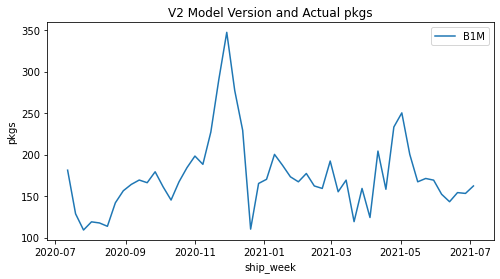

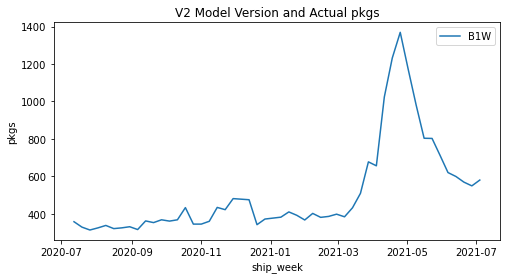

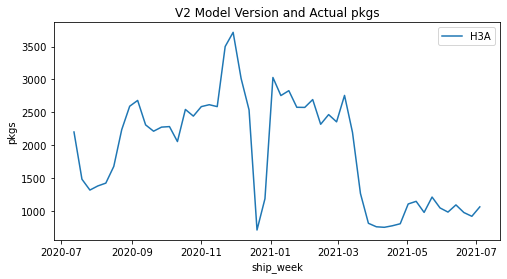

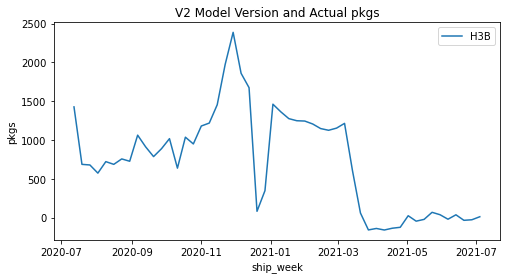

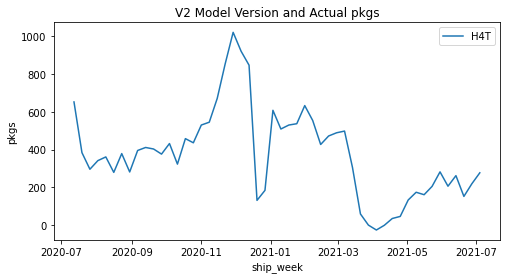

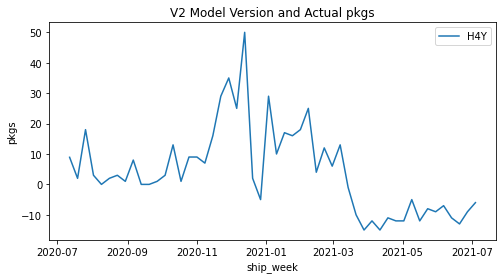

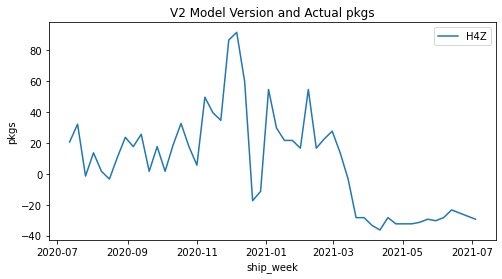

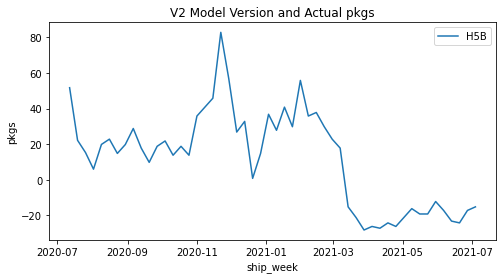

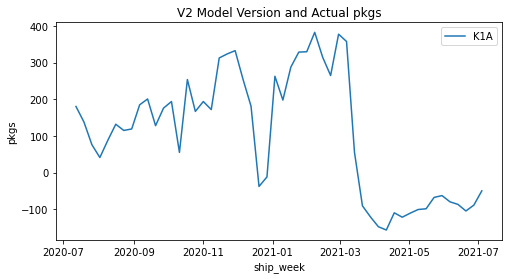

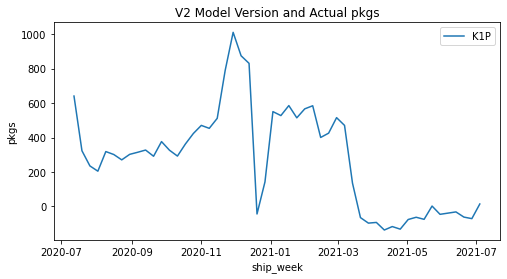

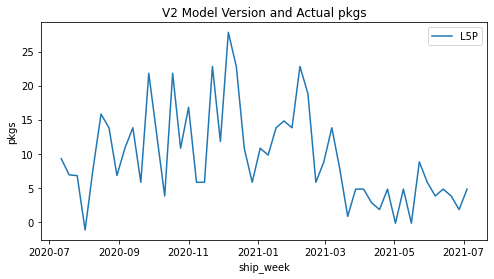

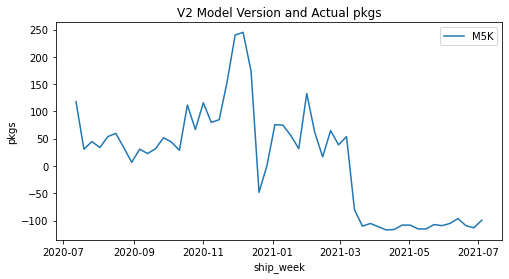

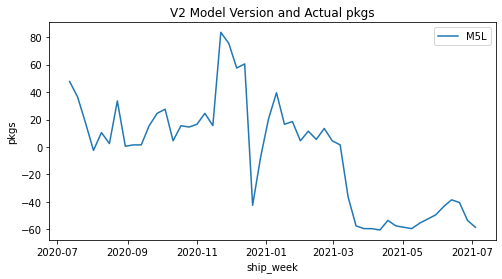

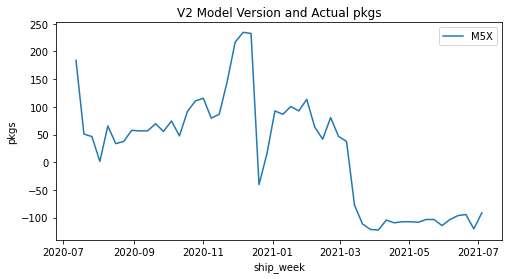

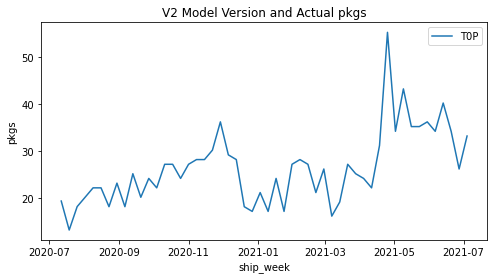

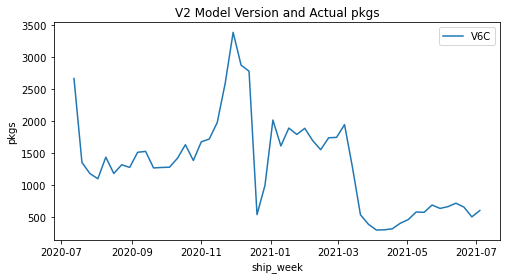

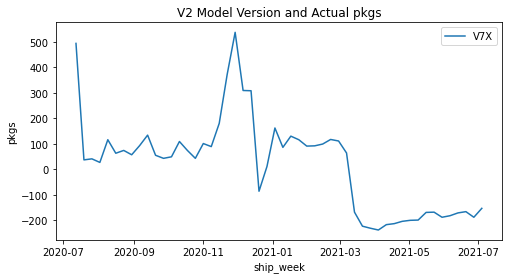

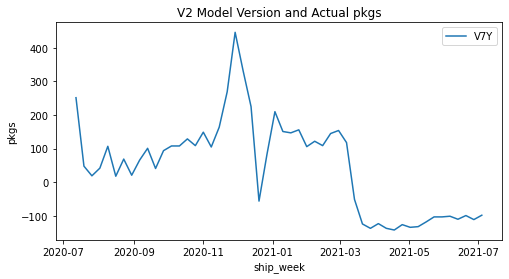

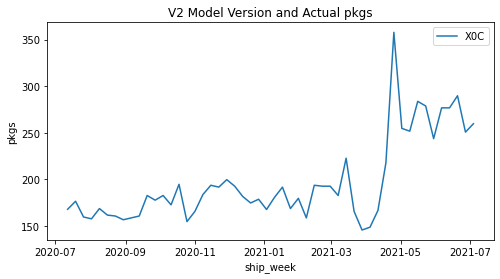

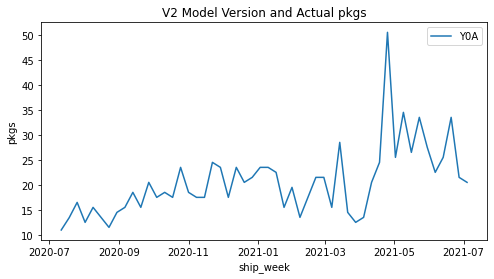

In [337]:
for key, grp in high_pred.groupby(['zipcode']):
    fig, ax = plt.subplots(figsize=(8,4))
    plt.plot(grp['ship_week'], grp['pred_V2'], label=key)
    #plt.plot([high_rst['zipcode']==key]['ship_week'], high_rst[high_rst['zipcode']==key]['pkgs'], label='actual')
    plt.title('V2 Model Version and Actual pkgs')
    plt.xlabel('ship_week')
    plt.ylabel('pkgs')
    plt.legend()
    plt.show()

## Multiprocessing Review

In [22]:
# define function 
def run_V2_models(df):
    
    zipcode = df[0]
    df = df[1]

    
    #input from the model 
    try:
        
    #df = df.set_index('ship_week')
        train_data = df[-4*212:160]
        test_data = df[-52:]
        fcst_data = df[-3*52:]
    
    
        train_data1 = train_data.iloc[:,1]
        test_data1 = test_data.iloc[:,1]
        fcst = fcst_data.iloc[:,1]
    
        best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
        pred = best_model.predict(start=160, end=160+52-1)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
    
    
        best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        fct = best_model_fct.predict(start=160, end=160+352-1)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    
    except:
        print(df['zipcode'].unique()[0])
        pred = np.full(len(test_data1), np.nan)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
        fct = np.full(len(fcst), np.nan)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    return pred, fct

In [76]:
# result = run_V2_models(mod_df[mod_df['zipcode']=='R0K'])
# result

In [224]:
#207 into 8 parts 
# num_fsa = int(len(mod_df.zipcode.unique()) / mp.cpu_count()) + 1
# num_fsa

In [201]:
#list of the FSA
#grp_fsa = list(zip_longest(*(iter(pd.unique(mod_df['zipcode'])),) * num_fsa))
#grp_fsa

In [210]:
#grp_fsa = list(pd.unique(mod_df['zipcode']))
#grp_fsa

In [211]:
## covert list of FSAs into a dict
# df_dict = dict(tuple(mod_df.groupby('zipcode')))
#df_dict

In [220]:
#fsa_list = [pd.concat([df_dict.get(key) for key in y]) for y in grp_fsa]
#fsa_list

In [23]:
 p = mp.Pool(mp.cpu_count())

In [24]:
results = p.map(run_V2_models, mod_df.groupby('zipcode'))

In [45]:
#results[0]

In [33]:
results_pred=[]
results_fct=[]

for res in results:
    
    pred = res[0]
    fct = res[1]
    
    results_pred.append(pred)
    results_fct.append(fct)

In [35]:
#results_pred

In [37]:
#results_fct

In [40]:
def run_V2(df):
    
    zipcode = df[0]
    df = df[1]

    
    #input from the model 
    try:
        
    #df = df.set_index('ship_week')
        train_data = df[-4*212:160]
        test_data = df[-52:]
        fcst_data = df[-3*52:]
    
    
        train_data1 = train_data.iloc[:,1]
        test_data1 = test_data.iloc[:,1]
        fcst = fcst_data.iloc[:,1]
    
        best_model = SARIMAX(train_data1, order=(0, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
        pred = best_model.predict(start=160, end=160+52-1)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
    
    
        best_model_fct = SARIMAX(fcst, order=(0, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        fct = best_model_fct.predict(start=160, end=160+352-1)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    
    except:
        print(df['zipcode'].unique()[0])
        pred = np.full(len(test_data1), np.nan)
        pred = pd.DataFrame(pred)
        pred.columns= ['pred_V2']
        pred['zipcode'] = df['zipcode'].unique()[0]
        fct = np.full(len(fcst), np.nan)
        fct = pd.DataFrame(fct) 
        fct.columns = ['pred_V2']
        fct['zipcode'] = df['zipcode'].unique()[0]
    
    return pred, fct

In [41]:
p = mp.Pool(mp.cpu_count())

In [42]:
results = p.map(run_V2, mod_df.groupby('zipcode'))

In [9]:
#results

## Prophet Model 

In [29]:
#pip install pystan

In [30]:
#pip install fbprophet

In [32]:
# from fbprophet import Prophet 
# from datetime import datetime

In [31]:
#pip install plotly 

In [36]:
# train_data = post_code[-4*212:156]
# test_data = post_code[-52:]
# fcst_data = post_code[-3*52:]

In [33]:
# train = train_data.iloc[:,1]
# train

In [23]:
#dir(prophet)

In [40]:
#train['ds'] = train['ship_week']
#train['y'] = train['pkgs']
#train.columns = ['ds', 'y']
#train.head()

In [34]:
# data = train.to_frame()
# data_train = data.reset_index()
# data_train.columns =['ship_week', 'pkgs_num']
# data_train.head()

In [35]:
# data_train.columns = ['ds', 'y']
# data_train.head()

In [38]:
#data_train.dtypes

In [28]:
# #perform Box-Cox transformation on original data
# from scipy.stats import boxcox

# #transformed_data, best_lambda = boxcox(data_train['y']) 

# data_train['y'], lam = boxcox(data_train['y'])

In [36]:
#$data_train.tail()

In [37]:
#data_train.shape

In [26]:
# #new_model_test = prophet()
# #new_model_test.fit(data_train)
# #rom fbprophet import prophet
# m = Prophet()
# m.fit(data_train)

In [25]:

# future = m.make_future_dataframe(periods=352, freq='W')
# #future = (start=156, end=156+352-1)
# future.tail()

In [24]:
# forecast = m.predict(future)
# forecast

In [2]:
from fbprophet import Prophet 
from datetime import datetime

In [3]:
def run_V3_models(df):
    
        zipcode = df[0]
        df = df[1]
        
    #input from the model 
        #training the model
        
        train_data = df[-4*212:160]
        print(train_data)
        train = train_data.iloc[:,1]
        data = train.to_frame()
        data_train = data.reset_index()
        data_train.columns =['ship_week', 'pkgs_num']
        
        #change the column names 
        data_train.columns = ['ds', 'y']
        
        #fit model
        m = Prophet(interval_width=0.95, weekly_seasonality=True)
        model = m.fit(data_train)
        future = m.make_future_dataframe(periods=52, freq='W')
        
        forecast = m.predict(future)
        forecast = pd.DataFrame(forecast)
       # forecast.columns= ['pred_V3']
        forecast['zipcode'] = df['zipcode'].unique()[0]
    
        return forecast

In [4]:
p = mp.Pool(mp.cpu_count())

NameError: name 'mp' is not defined

In [ ]:
results = p.map(run_V3_models, mod_df.groupby('zipcode'))

In [ ]:
df_pred = pd.DataFrame(columns=['ds','trend','yhat_lower', 'yhat_upper',
                                'trend_lower', 'trend_upper', 
                                'additive_terms', 'additive_terms_lower', 
                                'additive_terms_upper', 'weekly', 'weekly_lower', 
                                'weekly_upper', 'yearly', 
                                'yearly_lower', 'yearly_upper',
                                'multiplicative_terms','multiplicative_terms_lower', 
                                'multiplicative_terms_upper', 'yhat', 'zipcode'])
df_pred
for i in range(len(results)):
    df_pred = df_pred.append([results[i].reset_index()])    

In [ ]:
fct = df_pred[['ds', 'yhat', 'zipcode']]
fct

In [ ]:
fct.rename({'ds': 'ship_week', 'yhat': 'pred'}, axis=1, inplace=True)
fct.head(10)

In [ ]:
fsa = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
fsa

In [ ]:
pct = fsa.reset_index()
pct.head(10)

In [ ]:
fct_index = fct.set_index('ship_week')
fct_index

In [ ]:
mod_fct=fct_index[fct_index.index >='2018-12-30']
mod_fct

In [ ]:
prop_v3 = mod_fct.groupby(['ship_week','zipcode']).sum()/mod_fct.groupby(['ship_week']).sum()
prop_v3

In [ ]:
prop_v3_rst = prop_v3.reset_index()
prop_v3_rst

In [ ]:
pred_v3_merge = pd.merge(prop_v3_rst, pct,  on=["ship_week", "zipcode"])
pred_v3_merge

In [ ]:
pred_v3_merge['pct_mix'] = pred_v3_merge['pkgs'] - pred_v3_merge['pred']

pred_v3_merge['pct_mix']= pred_v3_merge['pct_mix'].abs()

pred_v3_merge

In [ ]:
pred_v3_merge['APE'] = pred_v3_merge['pct_mix'] / pred_v3_merge['pkgs']
pred_v3_merge

In [ ]:
#MAPE
mape_v3 = pred_v3_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v3

In [ ]:
def my_agg(x):
    names = {'weighted_v3': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v3'])

In [ ]:
wape_v3 = pred_v3_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v3